In [ ]:
!pip install pmdarima -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00


### Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Reading the data
dataset = pd.read_csv('/content/SBI_minute_data_with_indicators.csv')

In [ ]:
# Dropping Columns
df_sbi = dataset[['close', 'date']]

In [ ]:
# Converting "date" to datetime
df_sbi['date'] = pd.to_datetime(df_sbi['date'], errors='coerce')

# errors='coerce', replace any parsing errors with NaT, won't get a ValueError for invalid date strings.

<ipython-input-5-bdd5e49d50ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sbi['date'] = pd.to_datetime(df_sbi['date'], errors='coerce')


In [ ]:
# Frequency Conversion
df_sbi['Date'] = df_sbi['date'].dt.date
df_sbi['Month'] = df_sbi['date'].dt.to_period('M')
df_sbi['Year'] = df_sbi['date'].dt.year

daily_data = df_sbi.groupby('Date').agg({'close': 'last'})
monthly_data = df_sbi.groupby('Month').agg({'close': 'last'})
yearly_data = df_sbi.groupby('Year').agg({'close': 'last'})

<ipython-input-6-f6c24914b335>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sbi['Date'] = df_sbi['date'].dt.date
<ipython-input-6-f6c24914b335>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_sbi['Month'] = df_sbi['date'].dt.to_period('M')
<ipython-input-6-f6c24914b335>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sbi['Month'] = df_sbi['date'].dt.to_period('M')
<ipython-input-6-f6c24914b335>:4: SettingWithCopyWarning: 
A value is trying to be

In [ ]:
# Setting Date as index
df_sbi.set_index('date', inplace=True)
df_sbi.head()

,close,Date,Month,Year
date,,,,
2015-02-02 10:18:00+05:30,309.35,2015-02-02,2015-02,2015
2015-02-02 10:19:00+05:30,308.80,2015-02-02,2015-02,2015
2015-02-02 10:20:00+05:30,308.75,2015-02-02,2015-02,2015
2015-02-02 10:21:00+05:30,308.80,2015-02-02,2015-02,2015
2015-02-02 10:22:00+05:30,309.30,2015-02-02,2015-02,2015


### Data Exploration

In [ ]:
# Checking for null values and Data type
print("Sbi Dataset Info: ")
print(df_sbi.info())

Sbi Dataset Info: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 671024 entries, 2015-02-02 10:18:00+05:30 to 2022-10-24 19:14:00+05:30
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype    
---  ------  --------------   -----    
 0   close   671024 non-null  float64  
 1   Date    671024 non-null  object   
 2   Month   671024 non-null  period[M]
 3   Year    671024 non-null  int64    
dtypes: float64(1), int64(1), object(1), period[M](1)
memory usage: 25.6+ MB
None


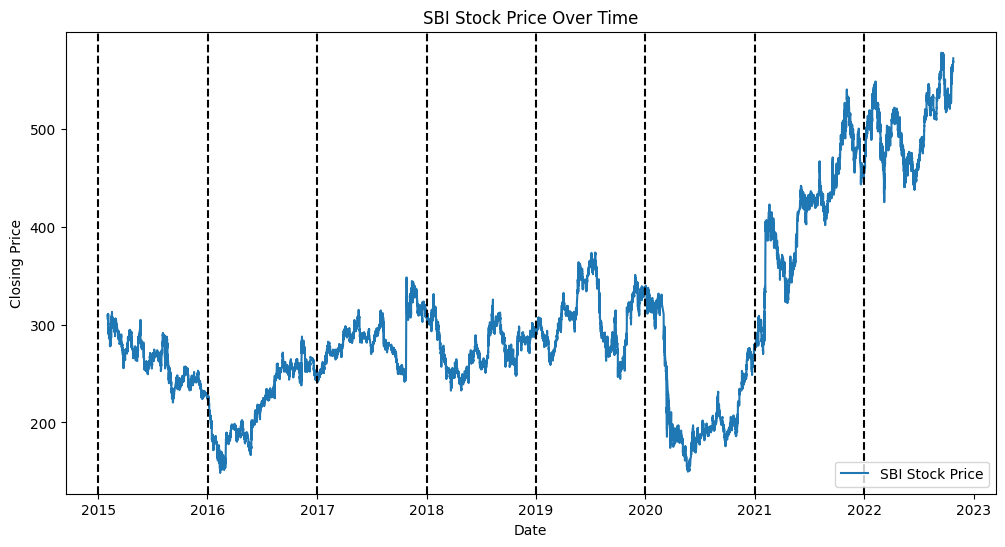

In [ ]:
#Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(df_sbi['close'], label='SBI Stock Price')
plt.title('SBI Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
for year in range(2015, 2023):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color="k", linestyle="--")
plt.legend()
plt.show()

The Moving Average (MA) (or) Rolling Mean is a measure that captures the average change in a data series over time.

A moving standard deviation (MSD) is a measure of market volatility, or how much prices are likely to fluctuate over a given period of time.


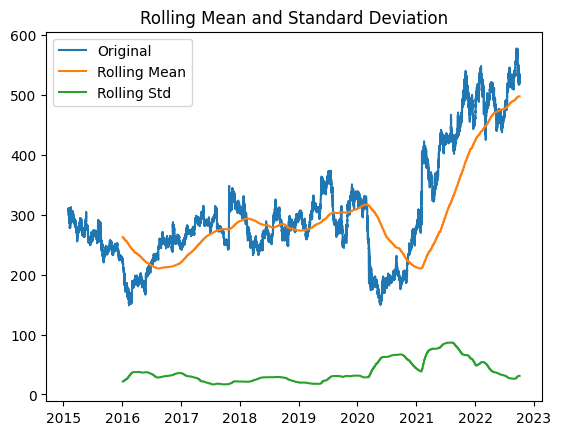

In [ ]:
# On average there are around 80k to 87k observation per year, we will analyze moving average Yearly. Therefore we set window = 80000
rolling_mean = df_sbi['close'].rolling(window=80000).mean()
rolling_std = df_sbi['close'].rolling(window=80000).std()

plt.plot(df_sbi['close'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()



The low volatility in the rolling standard deviation suggests that the data points are not exhibiting large fluctuations or variability. This could mean a period of stability in the market without significant price swings.

The increase in the rolling standard deviation from year 2020 to 2022 implies there was a notable increase in variability, these periods may coincide with significant events, news releases, or market shocks that caused increased uncertainty and sudden drop in the price movements.

When prices move wildly, standard deviation is high, meaning an investment will be risky. Low standard deviation means prices are calm, so investments come with low risk.






### Analyzing Components of Time Series.

**Trend** : A steady tendency of upward / downward movement in the average value of the forecast variable overtime.
When observations are plotted against time a straight line describes the increase or decrease

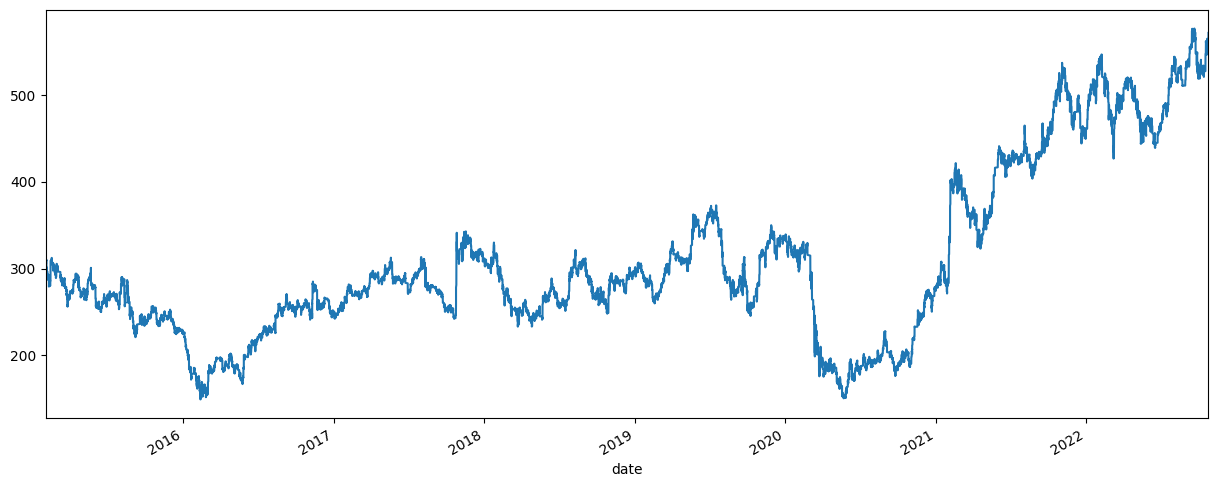

In [ ]:
#Plotting Trend Using Hp-filter
from statsmodels.tsa.filters.hp_filter import hpfilter
stock_cycle, stock_trend = hpfilter(df_sbi['close'], lamb=1600)
stock_trend.plot(figsize=(15,6)).autoscale(axis='x', tight=True)

We Observe that the Data is NOT Strictly Stationary. It has an upward TREND component

There are 2 types of trend:
1. **Deterministic Trend :** Trend that continuously increases or decreases
2. **Stochastic Trend :** Trend that increase or decrease inconsistently

The plotted graph shows a Stochastic Trend, where we observe and increase from 2016 to 2020, and after a sudden drop in prices, we again observe and increase from 2021 to 2023

Since the data has a trend component, we will try plotting data after removing the trend, one way to remove trend is by using the differencing step

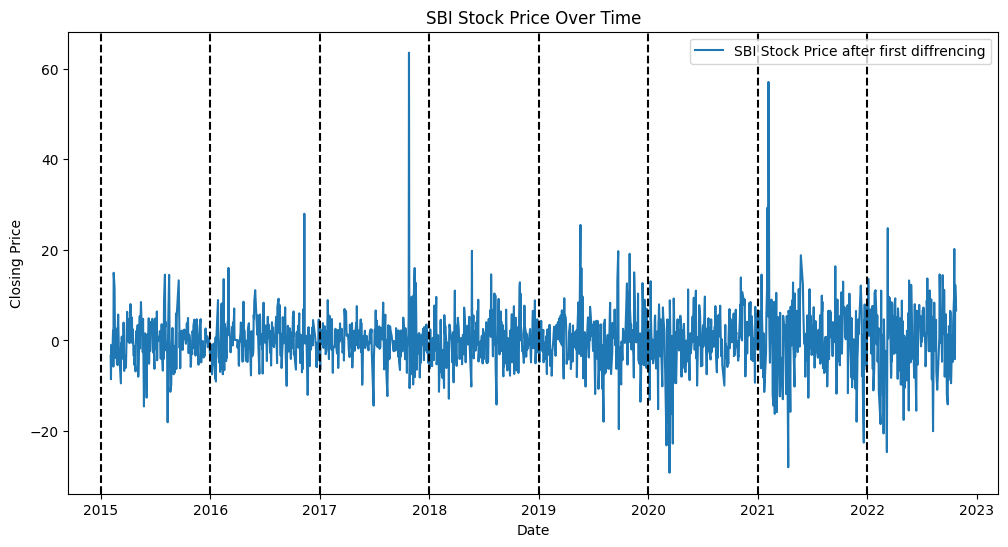

In [ ]:
df_sbi["first_diff"] = df_sbi['close'].diff()
plt.figure(figsize=(12, 6))
plt.plot(daily_data["first_diff"], label='SBI Stock Price after first diffrencing')
plt.title('SBI Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
for year in range(2015, 2023):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color="k", linestyle="--")
plt.legend()
plt.show()

We observe that the volatality of diff data is comparitively low, it doesnt reflect any prominant CYCLIC or SEASONAL component

**Cycles :** A pattern that repeats over time, but is not regular in length or amplitude. An upward or downward movement in the variable value over the trend line

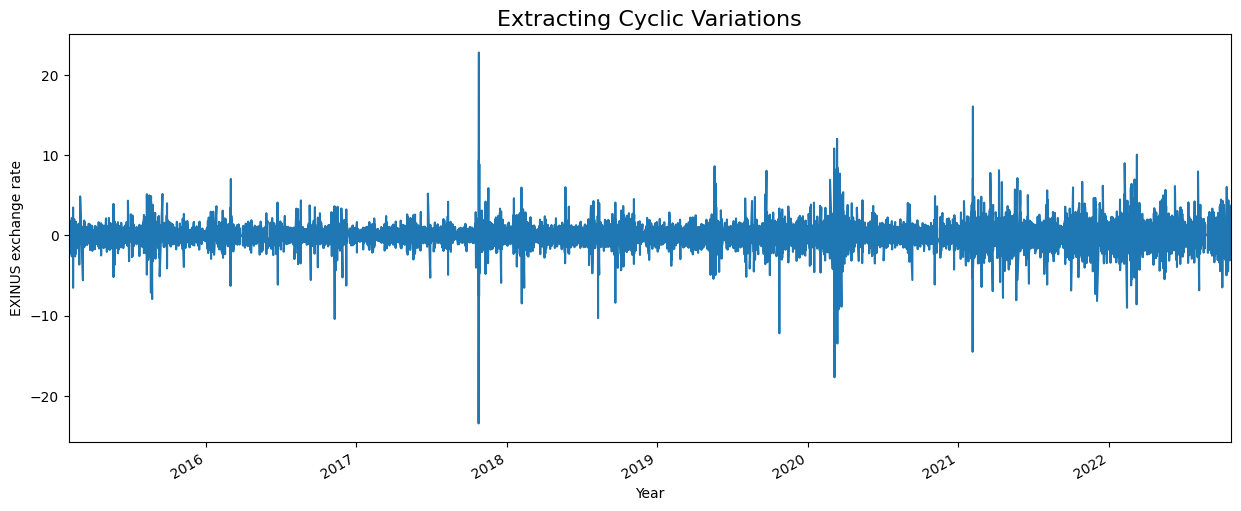

In [ ]:
#Detecting Cyclic Variations:
stock_cycle.plot(figsize=(15,6)).autoscale(axis='x',tight=True)
plt.title('Extracting Cyclic Variations', fontsize=16)
plt.xlabel('Year')
plt.ylabel('EXINUS exchange rate')
plt.show()

No significant cycles in the data

**Seasonality :** A special case of Cyclic Component, where fluctuations or patterns are repeated at regular interval (usually within a year)

<function matplotlib.pyplot.show(close=None, block=None)>

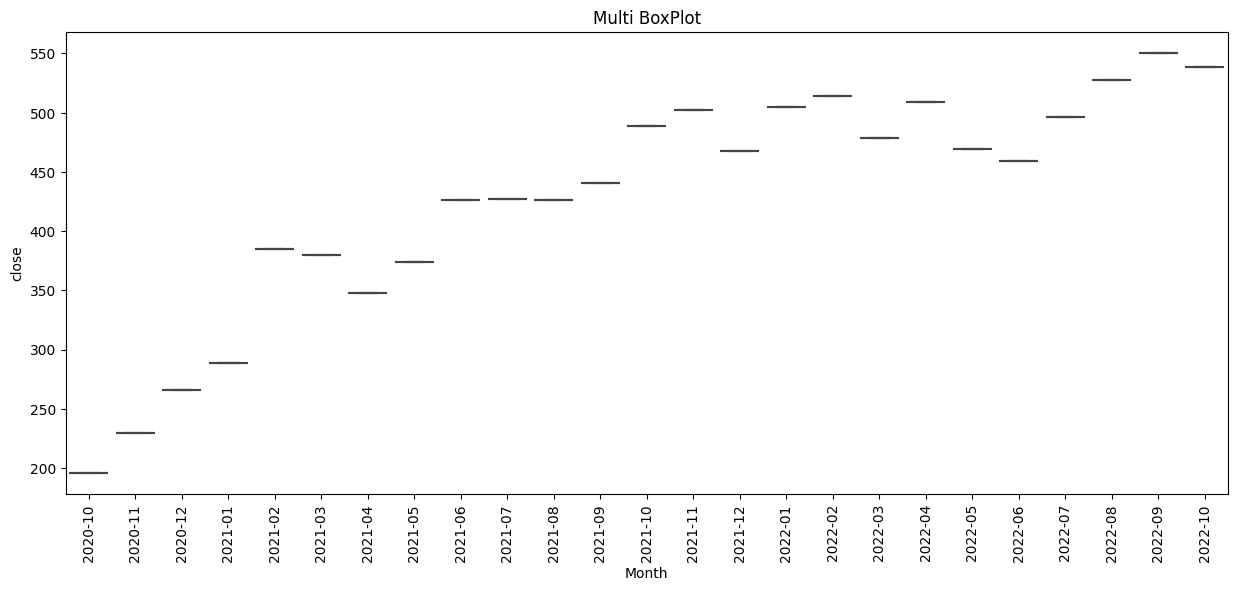

In [ ]:
#Detecting Seasonality of last 2 years using Multiple Box Plots:
df_Last2Years = monthly_data[monthly_data.index>"2020-9"]
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
sns.boxplot(x=df_Last2Years.index, y='close', data=df_Last2Years).set_title("Multi BoxPlot")
plt.show()

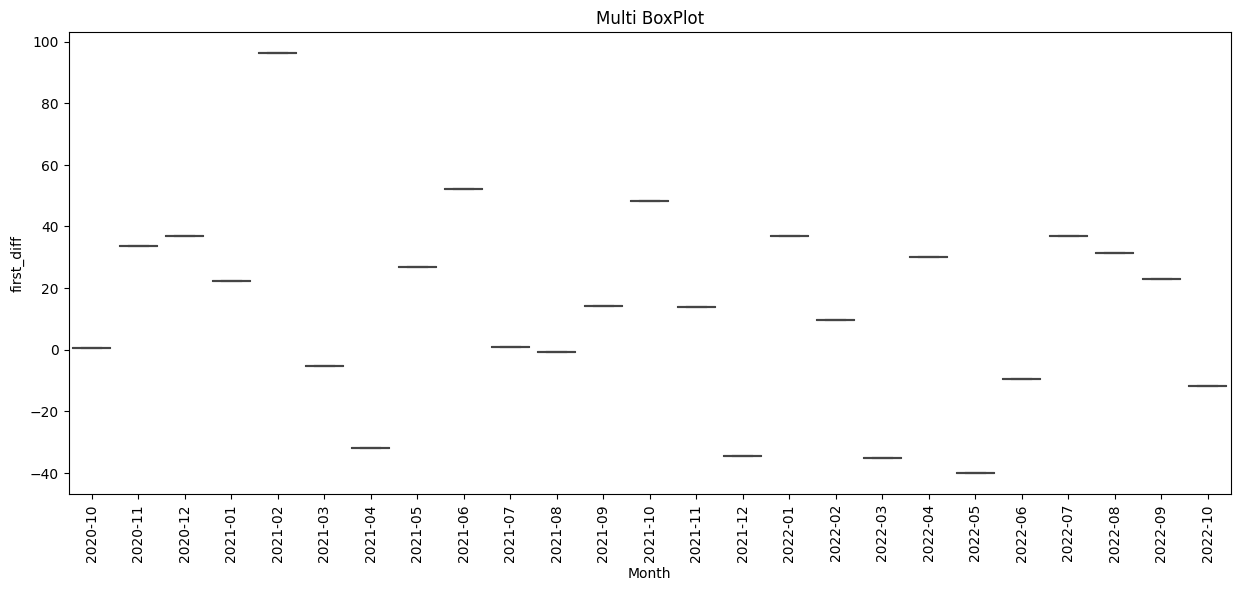

In [ ]:
## plotting Seasonality for first Differenced Data of last 2 years
monthly_data["first_diff"] = monthly_data['close'].diff()
df_Last2Years = monthly_data[monthly_data.index>"2020-9"]
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
sns.boxplot(x=df_Last2Years.index, y='first_diff', data=df_Last2Years).set_title("Multi BoxPlot")
plt.show()

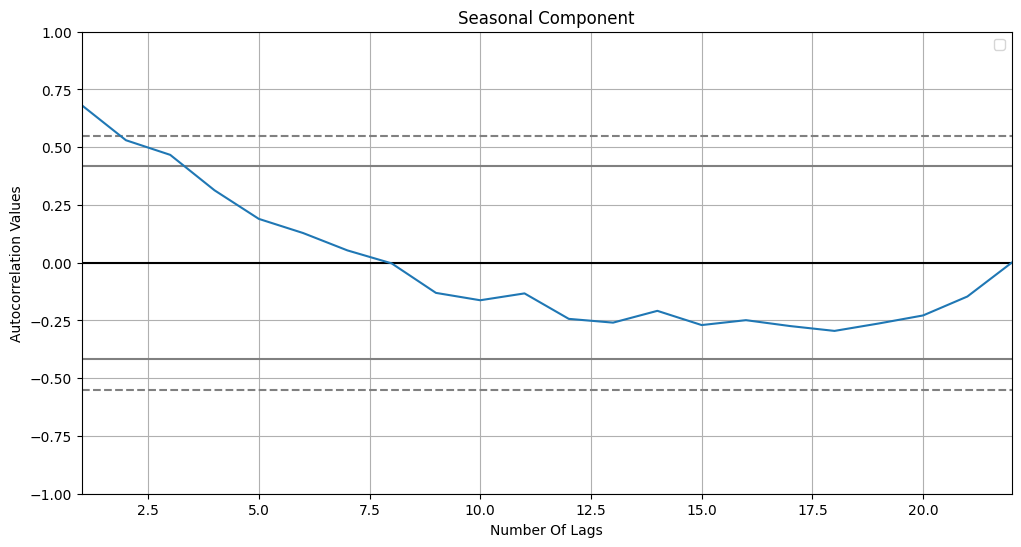

In [ ]:
#Detecting Seasonality component from autocorrelation_plot
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(12, 6))
autocorrelation_plot(df_Last2Years["close"])
plt.title('Seasonal Component')
plt.xlabel('Number Of Lags')
plt.ylabel('Autocorrelation Values')
plt.legend()
plt.show()

# Points above or below the line indicate statistically significant positive / negative autocorrelation.

From the above 3 plots, We tried predicting presence of seasonal component in monthly dataset, but we don't see any repeating patterns. We don't see any Significant Seasonal Component

### Data Decomposition

There are 2 types of seasonality:
1. **Additive Seasonality**: Seasonal pattern in consistent, magnitude of seasonal effect is relatively constant

2. **Multiplicative Seasonality**: Seasonal pattern in not consistent, magnitude of seasonal effect varies

Since our data does not have any seasonal pattern, we can opt for simpler model i.e additive model

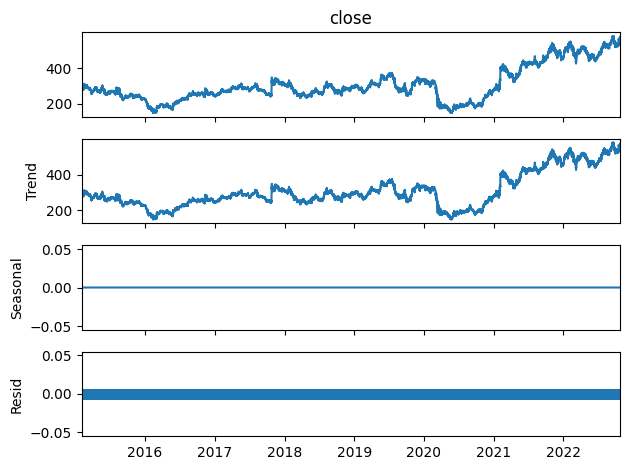

In [ ]:
#Decomposing Time Series Data into Trends, Seasonality, and Residual Component.

from statsmodels.tsa.seasonal import seasonal_decompose
decomposed_sbi = seasonal_decompose(df_sbi['close'], model='additive', period=1)

trend = decomposed_sbi.trend
seasonal = decomposed_sbi.seasonal
residual = decomposed_sbi.resid

plot = decomposed_sbi.plot()

A trend in a time series is a long-term increase or decrease in the level of the series. In our case we observe a gradual increase in data indicating presence of trend component

Seasonality is characterized by repeating patterns at regular intervals, but in this case, the values do not show a consistent, periodic variation.

The residual component represents the unexplained or random variation in the data after accounting for trend and seasonality. In this case, the values are constant that shows that the seasonal_decompose has successfully captured major patterns, and the data has minimal unexplained variability.


### Check for stationarity

A time series is said to be stationary if its statistical properties, such as mean, variance, and autocorrelation, remain constant over time.

Stationarity is crucial in time series analysis because many statistical methods and models assume or work better with stationary data. When a time series is non-stationary, it might be necessary to apply transformations or differencing to make it stationary before applying certain models, such as autoregressive integrated moving average (ARIMA) models.

A formal test for checking stationarity is (DF) and Augmented Dickey Fuller Test (ADF)



In [ ]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series)

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used ','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05 :
        if(dftest[0]<=dftest[4]["1%"] or dftest[0]<= dftest[4]["5%"] or dftest[0]<= dftest[4]["10%"]):

          print("Conclusion:====>")
          print("Reject the null hypothesis")
          print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

Augmented_Dickey_Fuller_Test_func(daily_data['close'].dropna() ,'close')

Results of Dickey-Fuller Test for column: close
Test Statistic                   -0.437386
p-value                           0.903667
No Lags Used                      6.000000
Number of Observations Used    1790.000000
Critical Value (1%)              -3.434008
Critical Value (5%)              -2.863156
Critical Value (10%)             -2.567630
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


**Conditions to Reject Null Hypothesis(Ho):**

1. Test-statistic < Critical Value
2. p-value < 0.05

**Null Hypothesis (Ho)**: Series is non-stationary or series has a unit root.

**Alternate Hypothesis(Ha)**: Series is stationary or series has no unit root.



Since, the p-value is greater than significance level (0.05), we Fail to reject the Null Hypothesis, indicating that the data is non-stationary.

In [ ]:
#we need to make the data stationary before proceeding with further analysis
#One common method is to apply differencing to remove the trend
df_diff = daily_data.diff().dropna()

### ACF and PACF

In [ ]:
import statsmodels.tsa.api as smt
def plot_acf_pcf(data, lags):
  fig = plt.figure(figsize=(12, 4))
  layout = (1, 2)
  acf_ax = plt.subplot2grid(layout, (0, 0))
  pacf_ax = plt.subplot2grid(layout, (0, 1))

  # ACF Plot
  smt.graphics.plot_acf(data, lags=lags, ax=acf_ax)

  # PACF Plot
  smt.graphics.plot_pacf(data, lags=lags, ax=pacf_ax)

  plt.tight_layout()
  plt.show()

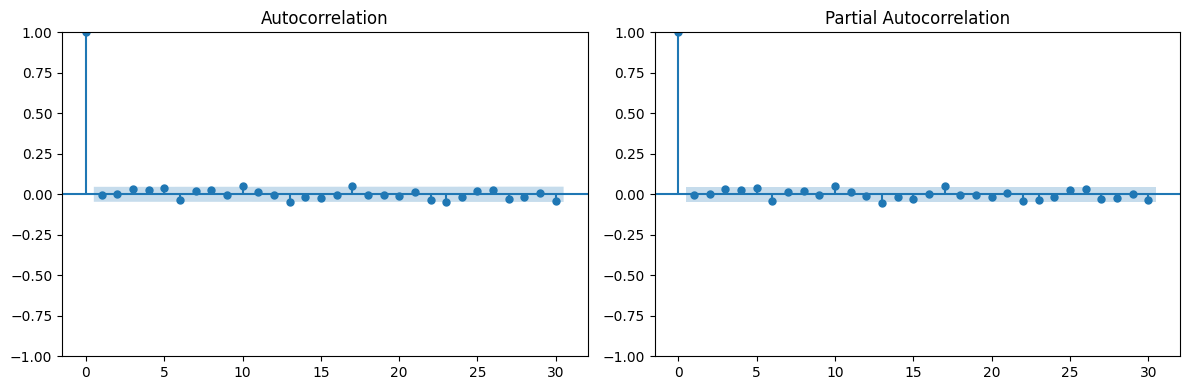

In [ ]:
plot_acf_pcf(df_diff["close"], 30)

# ACF: One or more spikes, rest are essentially zero
# PACF: Only 1 or 2 significant spikes, followed by insiginificants lags
# We use MA model

# ACF: Exponential/Sinosoidal/Linearly Decaying
# PACF: 1 or 2 significant spikes, followed by insiginificants lags
# We use AR model

# ACF: Exponential/Sinosoidal/Linearly Decaying
# PACF: Sinosoidal/Linearly Decaying
# We use ARMA / ARIMA model

# ACF: All zero or close to zero
# Conclusion : Data is essentially random.

# ACF: High values at fixed intervals
# Conclusion : Include seasonal autoregressive term.

# ACF: No decay to zero
# Conclusion : Series is not stationary

The plot is very difficult to interpret as it shows no significant lags at the beginning of both ACF and PACF plot.

Presence of Positively significant lags in both ACF and PACF suggest a potential autoregressive (AR) component.

Presence of Negatively significant lags in both ACF and PACF suggest a potential moving average (MA) component.

We already know that our data has Trend Component.

Therefore we will try fitting ARIMA model.

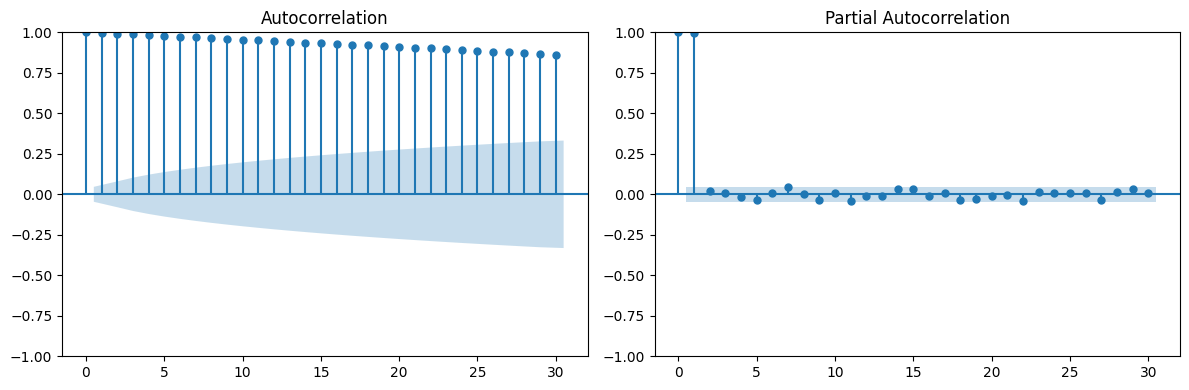

In [ ]:
# since diffrenced data didn't give any concreate information
# we will try on normal daily_data
plot_acf_pcf(daily_data["close"], 30)

This plot is much better


ACF follows a linear decaying pattern. This may imply that the stock prices exhibit a form of memory or dependence on past values.

The autocorrelation at lag 1 in the PACF suggests a strong correlation between consecutive observations.

From ACF we derive the MA order(q), From PACF we get the AR order(p).

### Train Test Split and Some Imp Fuctions

In [ ]:
X = daily_data['close']
train_size = int(len(X)*0.8) # 20% of data
test_size = int(len(X)*0.2) # 20% of data
train, test = X[0:train_size], X[-test_size:]

In [ ]:
import sklearn.metrics as metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def createForecastConfIntDF(forecast_, conf_int_):
  forecast = pd.DataFrame({"pred": forecast_}, index=test.index)
  df_conf = pd.DataFrame(conf_int_, columns=['Upper_bound', 'Lower_bound'], index=test.index)
  return forecast, df_conf

### ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 1, 1) )
results = model.fit()
results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1437
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4689.522
Date:                Mon, 25 Dec 2023   AIC                           9385.044
Time:                        00:33:43   BIC                           9400.853
Sample:                             0   HQIC                          9390.946
                               - 1437                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8825      0.138      6.418      0.000       0.613       1.152
ma.L1         -0.8643      0.146     -5.912      0.000      -1.151      -0.578
sigma2        40.1854      0.589     68.230      0.000      39.031      41.340
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              8938.80
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#forcasting
forecast_get = results.get_forecast(steps = test_size)

forecast_ = forecast_get.predicted_mean.values
conf_int_ = forecast_get.conf_int().values

forecast, df_conf = createForecastConfIntDF(forecast_, conf_int_)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 16568.46698090989
MAE is : 118.78267937548068
RMSE is : 128.71855725150857
MAPE is : 24.22652943067013
R2 is : -5.174415910072644



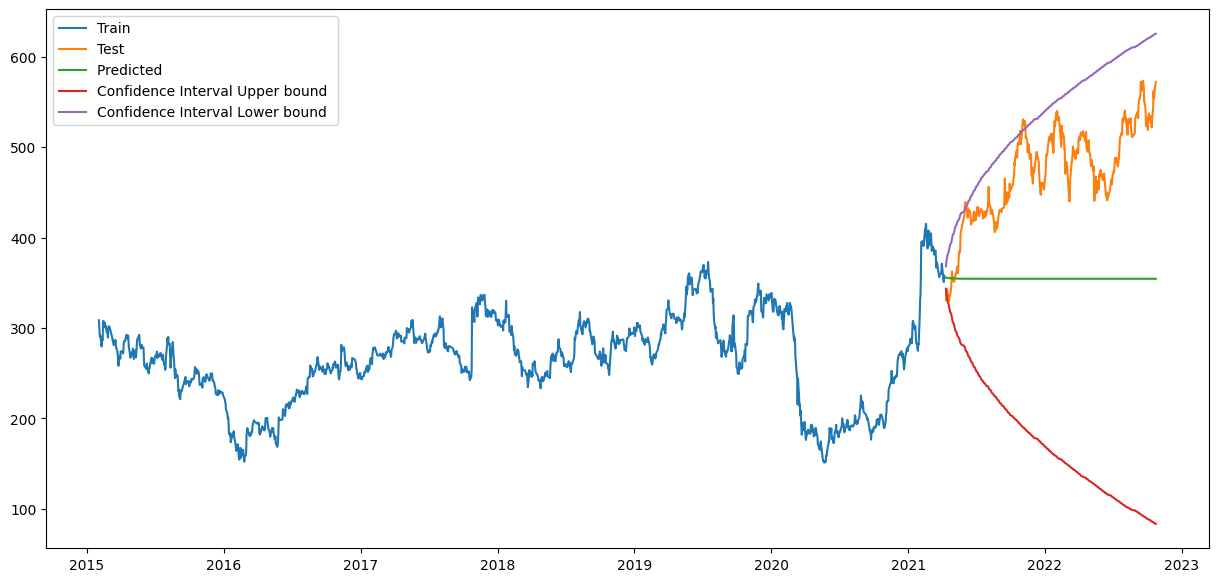

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,7]
plt.plot(train, label='Train')
plt.plot(test, label='Test ')
plt.plot(forecast['pred'], label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

### Auto Arima models

In [ ]:
from pmdarima import auto_arima
stepwise_model = auto_arima(train,start_p=1, start_q=1,
                            d=None, trace=True,
                            error_action='ignore',suppress_warnings=True, stepwise=True)
# Model summary
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9387.020, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9385.152, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9387.089, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9387.092, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9383.191, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.364 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1437
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4690.596
Date:                Mon, 25 Dec 2023   AIC                           9383.191
Time:                        00:34:17   BIC                           9388.461
Sample:                             0   HQIC                          9385.159
                               - 1437                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        40.2461      0.564     71.365      0.000      39.141      41.351
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              9082.38
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#forcasting
forecast, conf_int = stepwise_model.predict(n_periods=test_size, return_conf_int=True)
forecast, df_conf = createForecastConfIntDF(forecast.values, conf_int)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


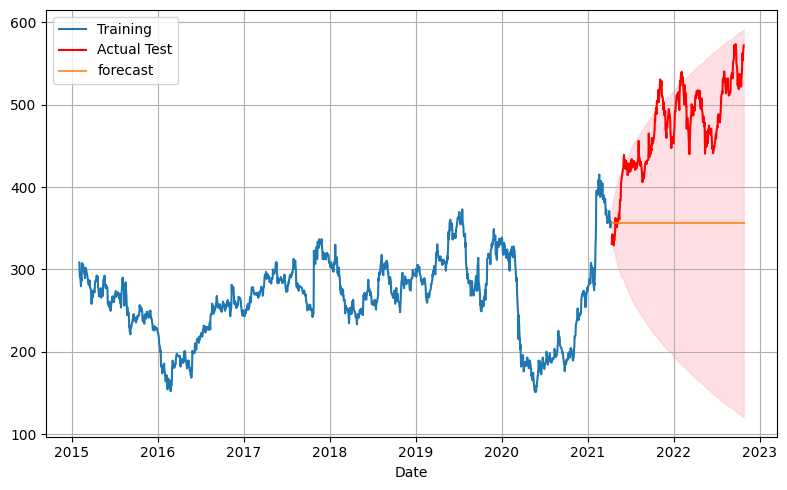

In [ ]:
# visualizing the results
plt.figure(figsize = (8,5))
train.plot(legend = True , label = 'Training' )
test.plot(legend = True , label = 'Actual Test' , color = 'red')
forecast["pred"].plot(legend = True , alpha= 0.8 ,label = 'forecast')
plt.fill_between(test.index  , df_conf["Lower_bound"] , df_conf["Upper_bound"] , color = 'pink' , alpha = 0.5)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 16210.035856545963
MAE is : 117.34721448467967
RMSE is : 127.31863907749707
MAPE is : 23.93732513637005
R2 is : -5.040842729193098



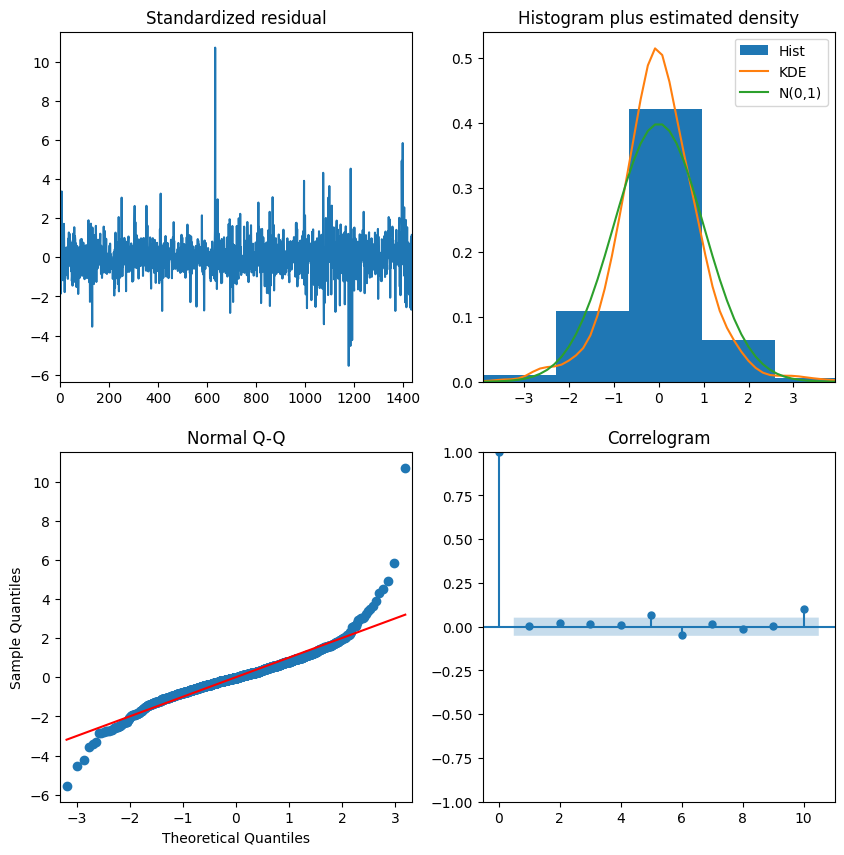

In [ ]:
stepwise_model.plot_diagnostics(figsize=(10, 10));

### Prophet

In [ ]:
split_date = pd.to_datetime("2022-01-01").date()
train_df = daily_data[daily_data.index < split_date].copy()
test_df = daily_data[daily_data.index >= split_date].copy()

In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly

In [ ]:
#Prophet expects the dataset to be names a specific way
#Datetime column named: ds
#target named: y

train_df["ds"] = train_df.index
train_df.rename(columns = {"close": "y"}, inplace=True)

test_df["ds"] = test_df.index
test_df.rename(columns = {"close": "y"}, inplace=True)

In [ ]:
model = Prophet(interval_width=0.95, daily_seasonality=True)
model.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpva1yvnja/9v6iwewc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpva1yvnja/rnt0ejq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62147', 'data', 'file=/tmp/tmpva1yvnja/9v6iwewc.json', 'init=/tmp/tmpva1yvnja/rnt0ejq9.json', 'output', 'file=/tmp/tmpva1yvnja/prophet_modelmyq6eove/prophet_model-20231224164209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# forecasting for the period of the test data
forecast = model.predict(test_df)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-03,530.134807,486.831724,576.685201,530.134807,530.134807,0.852236,0.852236,0.852236,-1.517774,...,-0.394135,-0.394135,-0.394135,2.764146,2.764146,2.764146,0.0,0.0,0.0,530.987043
1,2022-01-04,530.797627,485.688265,580.662814,530.797627,530.797627,0.737247,0.737247,0.737247,-1.517774,...,-0.920055,-0.920055,-0.920055,3.175076,3.175076,3.175076,0.0,0.0,0.0,531.534874
2,2022-01-05,531.460446,484.079745,580.092624,531.460446,531.460446,1.529673,1.529673,1.529673,-1.517774,...,-0.540723,-0.540723,-0.540723,3.588171,3.588171,3.588171,0.0,0.0,0.0,532.990120
3,2022-01-06,532.123266,488.137185,576.360397,532.094604,532.123266,2.241216,2.241216,2.241216,-1.517774,...,-0.239070,-0.239070,-0.239070,3.998060,3.998060,3.998060,0.0,0.0,0.0,534.364482
4,2022-01-07,532.786086,489.721231,578.223884,532.638671,532.829079,2.782763,2.782763,2.782763,-1.517774,...,-0.099192,-0.099192,-0.099192,4.399730,4.399730,4.399730,0.0,0.0,0.0,535.568849


In [ ]:
predictions = pd.Series(forecast.yhat.values , index = forecast.ds)

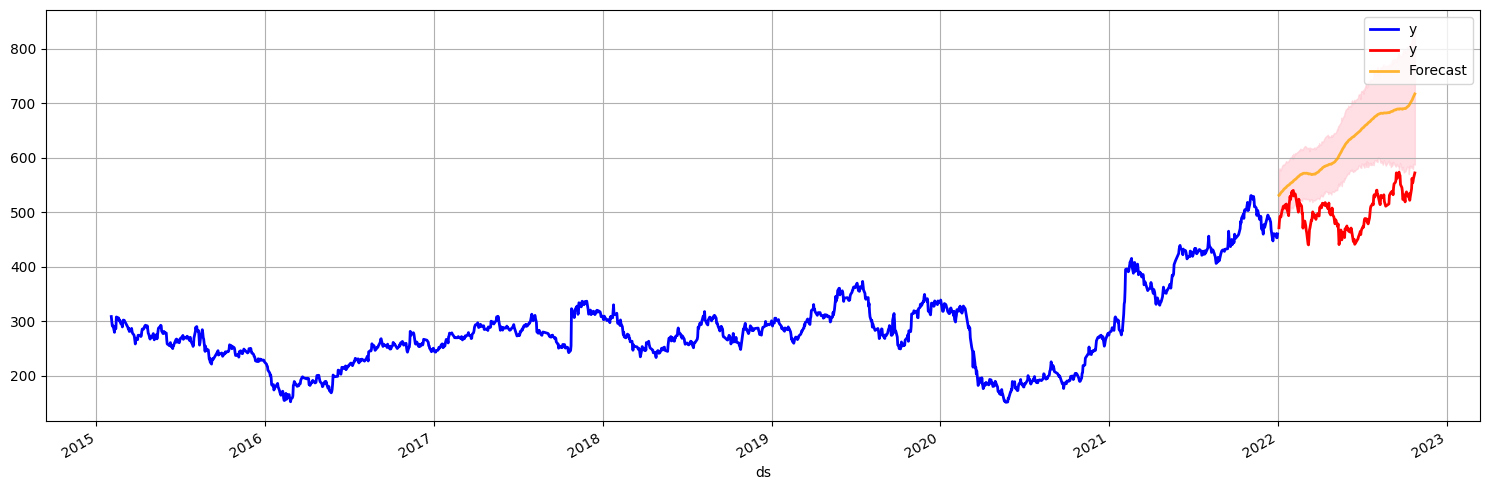

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(ax=ax, legend=True, label='Training', color='blue', linewidth=2)
test_df.plot(ax=ax, legend=True, label='Actual Test', color='red', linewidth=2)
predictions.plot(ax=ax, legend=True, label='Forecast', color='orange', alpha=0.8, linewidth=2)
plt.fill_between(forecast['ds']  , forecast["yhat_lower"] , forecast["yhat_upper"] , color = 'pink' , alpha = 0.5)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plot_plotly(model , forecast)

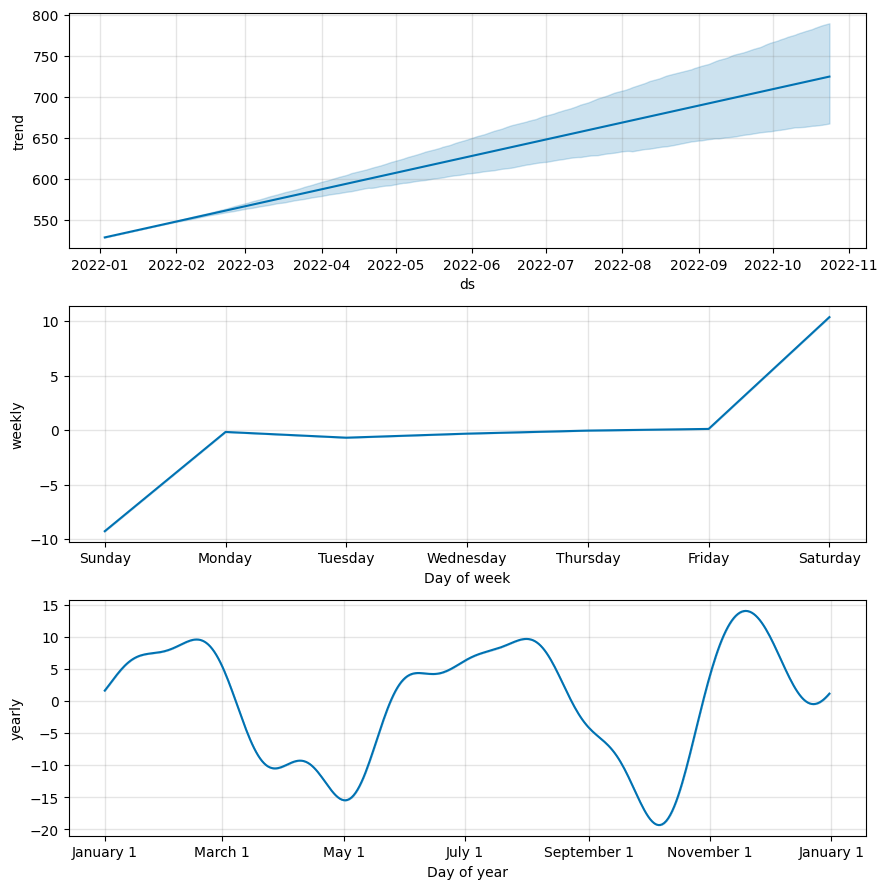

In [ ]:
fig = model.plot_components(forecast)
plt.show()

In [ ]:
timeseries_evaluation_metrics_func(test, forecast['yhat'][-test_size:])

Evaluation metric results:-
MSE is : 43147.672359320975
MAE is : 202.36736781452277
RMSE is : 207.720178026404
MAPE is : 42.2946009279075
R2 is : -15.079440240605926



In [ ]:
# make future dataset and predict into the future
future = model.make_future_dataframe(periods=30, include_history=False)
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01,527.698996,508.408416,570.242906,527.698996,527.698996,11.945152,11.945152,11.945152,10.380595,10.380595,10.380595,1.564557,1.564557,1.564557,0.0,0.0,0.0,539.644148
1,2022-01-02,528.364834,489.749650,550.460331,528.364834,528.364834,-7.322739,-7.322739,-7.322739,-9.279614,-9.279614,-9.279614,1.956875,1.956875,1.956875,0.0,0.0,0.0,521.042095
2,2022-01-03,529.030672,501.117857,563.054023,529.030672,529.030672,2.198258,2.198258,2.198258,-0.164420,-0.164420,-0.164420,2.362678,2.362678,2.362678,0.0,0.0,0.0,531.228930
3,2022-01-04,529.696510,501.533349,560.731522,529.696510,529.696510,2.084973,2.084973,2.084973,-0.691178,-0.691178,-0.691178,2.776151,2.776151,2.776151,0.0,0.0,0.0,531.781483
4,2022-01-05,530.362348,503.198514,563.234223,530.362348,530.362348,2.872298,2.872298,2.872298,-0.319349,-0.319349,-0.319349,3.191647,3.191647,3.191647,0.0,0.0,0.0,533.234646


Prophet also has a buildin ability to account for holidays. We can take into considerations some external events to improve the predictions

### Double Exponential Smoothening


1.   Handles data that consumes trends and seasonality.
2.   This method adds a time trend equation in the formulation.
3.    Two smoothing parameters are used to update these two components at a time.
4.   Also calleed as Holt's exponential smoothing that contains level, trends but no seasonality.

In [ ]:
from sklearn import metrics
from timeit import default_timer as timer
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'smoothing_level': [0.20,0.40,0.60,0.80],
              'smoothing_slope':[0.20,0.40,0.60,0.80],
              'damping_slope': [0.20,0.40,0.60,0.80],
              'damped' : [True, False]
              }
pg = list(ParameterGrid(param_grid))

In [ ]:
df_results_moni = pd.DataFrame(columns=['smoothing_level', 'smoothing_slope', 'damping_slope','damped','RMSE','r2'])
start = timer()
for a,b in enumerate(pg):
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope = damping_slope ,optimized=False)
    z = fit1.forecast(size)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test[:len(df_pred)], df_pred.Forecasted_result))
    r2 = metrics.r2_score(test[:len(df_pred)], df_pred.Forecasted_result)
    df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

0.2 0.2 0.2 True


<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope = damping_slope ,optimized=False)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope = damping_slope ,optimized=False)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead.
  return func(*args, **kwargs)
/usr/lo

80000    532.130628
80001    532.130159
80002    532.130066
80003    532.130047
80004    532.130043
            ...    
99995    532.130042
99996    532.130042
99997    532.130042
99998    532.130042
99999    532.130042
Length: 20000, dtype: float64
 RMSE is 18.173233915108245
0.2 0.4 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope = damping_slope ,optimized=False)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smooth

80000    532.116862
80001    532.115980
80002    532.115804
80003    532.115768
80004    532.115761
            ...    
99995    532.115760
99996    532.115760
99997    532.115760
99998    532.115760
99999    532.115760
Length: 20000, dtype: float64
 RMSE is 18.17933815161512
0.2 0.6 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.104033
80001    532.102789
80002    532.102540
80003    532.102490
80004    532.102480
            ...    
99995    532.102478
99996    532.102478
99997    532.102478
99998    532.102478
99999    532.102478
Length: 20000, dtype: float64
 RMSE is 18.185022865563685
0.2 0.8 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.092030
80001    532.090470
80002    532.090158
80003    532.090096
80004    532.090084
            ...    
99995    532.090080
99996    532.090080
99997    532.090080
99998    532.090080
99999    532.090080
Length: 20000, dtype: float64
 RMSE is 18.190336205783442
0.4 0.2 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.970038
80001    531.969926
80002    531.969904
80003    531.969900
80004    531.969899
            ...    
99995    531.969898
99996    531.969898
99997    531.969898
99998    531.969898
99999    531.969898
Length: 20000, dtype: float64
 RMSE is 18.242201075087234
0.4 0.4 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.961731
80001    531.961612
80002    531.961588
80003    531.961583
80004    531.961582
            ...    
99995    531.961582
99996    531.961582
99997    531.961582
99998    531.961582
99999    531.961582
Length: 20000, dtype: float64
 RMSE is 18.24581397566171
0.4 0.6 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.954238
80001    531.954210
80002    531.954204
80003    531.954203
80004    531.954203
            ...    
99995    531.954203
99996    531.954203
99997    531.954203
99998    531.954203
99999    531.954203
Length: 20000, dtype: float64
 RMSE is 18.249022195103425
0.4 0.8 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.947505
80001    531.947661
80002    531.947693
80003    531.947699
80004    531.947700
            ...    
99995    531.947700
99996    531.947700
99997    531.947700
99998    531.947700
99999    531.947700
Length: 20000, dtype: float64
 RMSE is 18.251851157058436
0.6 0.2 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.936620
80001    531.937161
80002    531.937269
80003    531.937291
80004    531.937295
            ...    
99995    531.937296
99996    531.937296
99997    531.937296
99998    531.937296
99999    531.937296
Length: 20000, dtype: float64
 RMSE is 18.25638163629323
0.6 0.4 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.934987
80001    531.936225
80002    531.936473
80003    531.936522
80004    531.936532
            ...    
99995    531.936535
99996    531.936535
99997    531.936535
99998    531.936535
99999    531.936535
Length: 20000, dtype: float64
 RMSE is 18.256713454605144
0.6 0.6 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.934395
80001    531.936478
80002    531.936894
80003    531.936978
80004    531.936994
            ...    
99995    531.936998
99996    531.936998
99997    531.936998
99998    531.936998
99999    531.936998
Length: 20000, dtype: float64
 RMSE is 18.256511433718405
0.6 0.8 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.934797
80001    531.937859
80002    531.938471
80003    531.938593
80004    531.938618
            ...    
99995    531.938624
99996    531.938624
99997    531.938624
99998    531.938624
99999    531.938624
Length: 20000, dtype: float64
 RMSE is 18.255803194440595
0.8 0.2 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.963082
80001    531.964339
80002    531.964590
80003    531.964640
80004    531.964650
            ...    
99995    531.964653
99996    531.964653
99997    531.964653
99998    531.964653
99999    531.964653
Length: 20000, dtype: float64
 RMSE is 18.24447953804668
0.8 0.4 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.968781
80001    531.971446
80002    531.971979
80003    531.972086
80004    531.972107
            ...    
99995    531.972112
99996    531.972112
99997    531.972112
99998    531.972112
99999    531.972112
Length: 20000, dtype: float64
 RMSE is 18.24123977855755
0.8 0.6 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.975417
80001    531.979613
80002    531.980452
80003    531.980620
80004    531.980653
            ...    
99995    531.980662
99996    531.980662
99997    531.980662
99998    531.980662
99999    531.980662
Length: 20000, dtype: float64
 RMSE is 18.237529932386902
0.8 0.8 0.2 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.982839
80001    531.988655
80002    531.989818
80003    531.990051
80004    531.990097
            ...    
99995    531.990109
99996    531.990109
99997    531.990109
99998    531.990109
99999    531.990109
Length: 20000, dtype: float64
 RMSE is 18.233434200095427
0.2 0.2 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.108693
80001    532.105747
80002    532.104568
80003    532.104097
80004    532.103908
            ...    
99995    532.103782
99996    532.103782
99997    532.103782
99998    532.103782
99999    532.103782
Length: 20000, dtype: float64
 RMSE is 18.184464213323412
0.2 0.4 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.077820
80001    532.072511
80002    532.070387
80003    532.069538
80004    532.069198
            ...    
99995    532.068971
99996    532.068971
99997    532.068971
99998    532.068971
99999    532.068971
Length: 20000, dtype: float64
 RMSE is 18.199399133905576
0.2 0.6 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.051134
80001    532.043924
80002    532.041040
80003    532.039887
80004    532.039425
            ...    
99995    532.039118
99996    532.039118
99997    532.039118
99998    532.039118
99999    532.039118
Length: 20000, dtype: float64
 RMSE is 18.212250588289212
0.2 0.8 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.027574
80001    532.018855
80002    532.015368
80003    532.013973
80004    532.013415
            ...    
99995    532.013043
99996    532.013043
99997    532.013043
99998    532.013043
99999    532.013043
Length: 20000, dtype: float64
 RMSE is 18.223507875132626
0.4 0.2 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.954311
80001    531.952342
80002    531.951555
80003    531.951240
80004    531.951114
            ...    
99995    531.951030
99996    531.951030
99997    531.951030
99998    531.951030
99999    531.951030
Length: 20000, dtype: float64
 RMSE is 18.250402239141906
0.4 0.4 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.933874
80001    531.930979
80002    531.929821
80003    531.929358
80004    531.929172
            ...    
99995    531.929049
99996    531.929049
99997    531.929049
99998    531.929049
99999    531.929049
Length: 20000, dtype: float64
 RMSE is 18.259976404475943
0.4 0.6 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.917100
80001    531.914175
80002    531.913006
80003    531.912538
80004    531.912351
            ...    
99995    531.912226
99996    531.912226
99997    531.912226
99998    531.912226
99999    531.912226
Length: 20000, dtype: float64
 RMSE is 18.26731833924054
0.4 0.8 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.903374
80001    531.901220
80002    531.900358
80003    531.900013
80004    531.899876
            ...    
99995    531.899784
99996    531.899784
99997    531.899784
99998    531.899784
99999    531.899784
Length: 20000, dtype: float64
 RMSE is 18.27275642158699
0.6 0.2 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.927326
80001    531.927813
80002    531.928008
80003    531.928086
80004    531.928117
            ...    
99995    531.928138
99996    531.928138
99997    531.928138
99998    531.928138
99999    531.928138
Length: 20000, dtype: float64
 RMSE is 18.2603735482381
0.6 0.4 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.920581
80001    531.923200
80002    531.924248
80003    531.924667
80004    531.924834
            ...    
99995    531.924946
99996    531.924946
99997    531.924946
99998    531.924946
99999    531.924946
Length: 20000, dtype: float64
 RMSE is 18.261765859111016
0.6 0.6 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.918605
80001    531.924852
80002    531.927351
80003    531.928351
80004    531.928751
            ...    
99995    531.929018
99996    531.929018
99997    531.929018
99998    531.929018
99999    531.929018
Length: 20000, dtype: float64
 RMSE is 18.259990070032732
0.6 0.8 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.921129
80001    531.932396
80002    531.936902
80003    531.938705
80004    531.939426
            ...    
99995    531.939907
99996    531.939907
99997    531.939907
99998    531.939907
99999    531.939907
Length: 20000, dtype: float64
 RMSE is 18.255244509202473
0.8 0.2 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.962377
80001    531.965948
80002    531.967377
80003    531.967948
80004    531.968176
            ...    
99995    531.968329
99996    531.968329
99997    531.968329
99998    531.968329
99999    531.968329
Length: 20000, dtype: float64
 RMSE is 18.242882742851833
0.8 0.4 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.972420
80001    531.981540
80002    531.985188
80003    531.986648
80004    531.987231
            ...    
99995    531.987620
99996    531.987620
99997    531.987620
99998    531.987620
99999    531.987620
Length: 20000, dtype: float64
 RMSE is 18.23451259139949
0.8 0.6 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.987628
80001    532.003853
80002    532.010343
80003    532.012939
80004    532.013978
            ...    
99995    532.014670
99996    532.014670
99997    532.014670
99998    532.014670
99999    532.014670
Length: 20000, dtype: float64
 RMSE is 18.222804379950215
0.8 0.8 0.4 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.006899
80001    532.031304
80002    532.041066
80003    532.044971
80004    532.046533
            ...    
99995    532.047574
99996    532.047574
99997    532.047574
99998    532.047574
99999    532.047574
Length: 20000, dtype: float64
 RMSE is 18.20860620306886
0.2 0.2 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.075409
80001    532.065480
80002    532.059523
80003    532.055949
80004    532.053804
            ...    
99995    532.050588
99996    532.050588
99997    532.050588
99998    532.050588
99999    532.050588
Length: 20000, dtype: float64
 RMSE is 18.207308196539856
0.2 0.4 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.024514
80001    532.007307
80002    531.996983
80003    531.990789
80004    531.987072
            ...    
99995    531.981497
99996    531.981497
99997    531.981497
99998    531.981497
99999    531.981497
Length: 20000, dtype: float64
 RMSE is 18.237167406930965
0.2 0.6 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.982643
80001    531.959996
80002    531.946408
80003    531.938255
80004    531.933363
            ...    
99995    531.926026
99996    531.926026
99997    531.926026
99998    531.926026
99999    531.926026
Length: 20000, dtype: float64
 RMSE is 18.261294783357716
0.2 0.8 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.947114
80001    531.920672
80002    531.904807
80003    531.895288
80004    531.889577
            ...    
99995    531.881010
99996    531.881010
99997    531.881010
99998    531.881010
99999    531.881010
Length: 20000, dtype: float64
 RMSE is 18.280974584987575
0.4 0.2 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.928937
80001    531.919819
80002    531.914348
80003    531.911066
80004    531.909096
            ...    
99995    531.906142
99996    531.906142
99997    531.906142
99998    531.906142
99999    531.906142
Length: 20000, dtype: float64
 RMSE is 18.269976371619716
0.4 0.4 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.892906
80001    531.879290
80002    531.871120
80003    531.866218
80004    531.863277
            ...    
99995    531.858865
99996    531.858865
99997    531.858865
99998    531.858865
99999    531.858865
Length: 20000, dtype: float64
 RMSE is 18.290688803011456
0.4 0.6 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.866575
80001    531.851629
80002    531.842661
80003    531.837281
80004    531.834052
            ...    
99995    531.829210
99996    531.829210
99997    531.829210
99998    531.829210
99999    531.829210
Length: 20000, dtype: float64
 RMSE is 18.303731428913697
0.4 0.8 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.846240
80001    531.832204
80002    531.823783
80003    531.818730
80004    531.815698
            ...    
99995    531.811151
99996    531.811151
99997    531.811151
99998    531.811151
99999    531.811151
Length: 20000, dtype: float64
 RMSE is 18.311692950508615
0.6 0.2 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.908656
80001    531.904183
80002    531.901499
80003    531.899888
80004    531.898922
            ...    
99995    531.897473
99996    531.897473
99997    531.897473
99998    531.897473
99999    531.897473
Length: 20000, dtype: float64
 RMSE is 18.273767065091235
0.6 0.4 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.892341
80001    531.890109
80002    531.888770
80003    531.887966
80004    531.887484
            ...    
99995    531.886761
99996    531.886761
99997    531.886761
99998    531.886761
99999    531.886761
Length: 20000, dtype: float64
 RMSE is 18.27845557300189
0.6 0.6 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.886911
80001    531.892526
80002    531.895895
80003    531.897916
80004    531.899129
            ...    
99995    531.900948
99996    531.900948
99997    531.900948
99998    531.900948
99999    531.900948
Length: 20000, dtype: float64
 RMSE is 18.27224717049381
0.6 0.8 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.891892
80001    531.910895
80002    531.922298
80003    531.929139
80004    531.933243
            ...    
99995    531.939401
99996    531.939401
99997    531.939401
99998    531.939401
99999    531.939401
Length: 20000, dtype: float64
 RMSE is 18.255464986360142
0.8 0.2 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.952536
80001    531.954897
80002    531.956313
80003    531.957163
80004    531.957673
            ...    
99995    531.958438
99996    531.958438
99997    531.958438
99998    531.958438
99999    531.958438
Length: 20000, dtype: float64
 RMSE is 18.247180387447795
0.8 0.4 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.963934
80001    531.977578
80002    531.985764
80003    531.990676
80004    531.993623
            ...    
99995    531.998044
99996    531.998044
99997    531.998044
99998    531.998044
99999    531.998044
Length: 20000, dtype: float64
 RMSE is 18.22999715399746
0.8 0.6 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.989691
80001    532.021688
80002    532.040885
80003    532.052404
80004    532.059315
            ...    
99995    532.069682
99996    532.069682
99997    532.069682
99998    532.069682
99999    532.069682
Length: 20000, dtype: float64
 RMSE is 18.19909366988712
0.8 0.8 0.6 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.026994
80001    532.082402
80002    532.115647
80003    532.135594
80004    532.147562
            ...    
99995    532.165515
99996    532.165515
99997    532.165515
99998    532.165515
99999    532.165515
Length: 20000, dtype: float64
 RMSE is 18.158113036572548
0.2 0.2 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.024036
80001    531.998497
80002    531.978066
80003    531.961722
80004    531.948646
            ...    
99995    531.896343
99996    531.896343
99997    531.896343
99998    531.896343
99999    531.896343
Length: 20000, dtype: float64
 RMSE is 18.274261253366035
0.2 0.4 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.953570
80001    531.909024
80002    531.873388
80003    531.844878
80004    531.822071
            ...    
99995    531.730842
99996    531.730842
99997    531.730842
99998    531.730842
99999    531.730842
Length: 20000, dtype: float64
 RMSE is 18.34727030375165
0.2 0.6 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.881776
80001    531.823910
80002    531.777616
80003    531.740581
80004    531.710953
            ...    
99995    531.592442
99996    531.592442
99997    531.592442
99998    531.592442
99999    531.592442
Length: 20000, dtype: float64
 RMSE is 18.409243903155634
0.2 0.8 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.826626
80001    531.764473
80002    531.714751
80003    531.674973
80004    531.643151
            ...    
99995    531.515862
99996    531.515862
99997    531.515862
99998    531.515862
99999    531.515862
Length: 20000, dtype: float64
 RMSE is 18.443892273653162
0.4 0.2 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.886344
80001    531.858312
80002    531.835887
80003    531.817946
80004    531.803594
            ...    
99995    531.746185
99996    531.746185
99997    531.746185
99998    531.746185
99999    531.746185
Length: 20000, dtype: float64
 RMSE is 18.340451468972407
0.4 0.4 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.832396
80001    531.793288
80002    531.762002
80003    531.736973
80004    531.716950
            ...    
99995    531.636857
99996    531.636857
99997    531.636857
99998    531.636857
99999    531.636857
Length: 20000, dtype: float64
 RMSE is 18.38926518288441
0.4 0.6 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.804427
80001    531.763414
80002    531.730604
80003    531.704356
80004    531.683357
            ...    
99995    531.599364
99996    531.599364
99997    531.599364
99998    531.599364
99999    531.599364
Length: 20000, dtype: float64
 RMSE is 18.406125116367164
0.4 0.8 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.784830
80001    531.743395
80002    531.710248
80003    531.683730
80004    531.662515
            ...    
99995    531.577657
99996    531.577657
99997    531.577657
99998    531.577657
99999    531.577657
Length: 20000, dtype: float64
 RMSE is 18.415914076051404
0.6 0.2 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.875611
80001    531.854129
80002    531.836943
80003    531.823194
80004    531.812195
            ...    
99995    531.768198
99996    531.768198
99997    531.768198
99998    531.768198
99999    531.768198
Length: 20000, dtype: float64
 RMSE is 18.330686061273425
0.6 0.4 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.848090
80001    531.826190
80002    531.808669
80003    531.794653
80004    531.783440
            ...    
99995    531.738588
99996    531.738588
99997    531.738588
99998    531.738588
99999    531.738588
Length: 20000, dtype: float64
 RMSE is 18.343826534751184
0.6 0.6 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.837521
80001    531.827329
80002    531.819175
80003    531.812652
80004    531.807433
            ...    
99995    531.786559
99996    531.786559
99997    531.786559
99998    531.786559
99999    531.786559
Length: 20000, dtype: float64
 RMSE is 18.32255728528146
0.6 0.8 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.841239
80001    531.855693
80002    531.867255
80003    531.876506
80004    531.883906
            ...    
99995    531.913507
99996    531.913507
99997    531.913507
99998    531.913507
99999    531.913507
Length: 20000, dtype: float64
 RMSE is 18.266759074545806
0.8 0.2 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.929122
80001    531.918796
80002    531.910535
80003    531.903926
80004    531.898639
            ...    
99995    531.877491
99996    531.877491
99997    531.877491
99998    531.877491
99999    531.877491
Length: 20000, dtype: float64
 RMSE is 18.282516693456774
0.8 0.4 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.938947
80001    531.945651
80002    531.951014
80003    531.955304
80004    531.958737
            ...    
99995    531.972467
99996    531.972467
99997    531.972467
99998    531.972467
99999    531.972467
Length: 20000, dtype: float64
 RMSE is 18.24108611958648
0.8 0.6 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.976588
80001    532.019738
80002    532.054258
80003    532.081874
80004    532.103966
            ...    
99995    532.192337
99996    532.192337
99997    532.192337
99998    532.192337
99999    532.192337
Length: 20000, dtype: float64
 RMSE is 18.146716914517974
0.8 0.8 0.8 True


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    532.039009
80001    532.134307
80002    532.210546
80003    532.271537
80004    532.320330
            ...    
99995    532.515502
99996    532.515502
99997    532.515502
99998    532.515502
99999    532.515502
Length: 20000, dtype: float64
 RMSE is 18.01198652914498
0.2 0.2 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.898243
80001    531.849763
80002    531.801283
80003    531.752803
80004    531.704323
            ...    
99995   -437.454640
99996   -437.503120
99997   -437.551600
99998   -437.600079
99999   -437.648559
Length: 20000, dtype: float64
 RMSE is 569.4047875172054
0.2 0.4 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.939147
80001     531.836329
80002     531.733510
80003     531.630692
80004     531.527874
            ...     
99995   -1523.911233
99996   -1524.014051
99997   -1524.116869
99998   -1524.219687
99999   -1524.322506
Length: 20000, dtype: float64
 RMSE is 1196.679383759207
0.2 0.6 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.668364
80001     531.503691
80002     531.339019
80003     531.174347
80004     531.009675
            ...     
99995   -2760.950490
99996   -2761.115162
99997   -2761.279834
99998   -2761.444506
99999   -2761.609179
Length: 20000, dtype: float64
 RMSE is 1911.075934085679
0.2 0.8 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.573096
80001     531.433003
80002     531.292910
80003     531.152818
80004     531.012725
            ...     
99995   -2269.577341
99996   -2269.717433
99997   -2269.857526
99998   -2269.997618
99999   -2270.137711
Length: 20000, dtype: float64
 RMSE is 1627.3598837176644
0.4 0.2 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.809920
80001    531.736637
80002    531.663354
80003    531.590071
80004    531.516787
            ...    
99995   -933.486358
99996   -933.559641
99997   -933.632924
99998   -933.706207
99999   -933.779490
Length: 20000, dtype: float64
 RMSE is 855.8030639116151
0.4 0.4 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.727494
80001     531.631061
80002     531.534629
80003     531.438197
80004     531.341765
            ...     
99995   -1396.433987
99996   -1396.530419
99997   -1396.626851
99998   -1396.723284
99999   -1396.819716
Length: 20000, dtype: float64
 RMSE is 1123.1324742030927
0.4 0.6 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.723767
80001     531.642472
80002     531.561177
80003     531.479882
80004     531.398587
            ...     
99995   -1093.767165
99996   -1093.848460
99997   -1093.929755
99998   -1094.011050
99999   -1094.092345
Length: 20000, dtype: float64
 RMSE is 948.3717577471431
0.4 0.8 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.741728
80001    531.667700
80002    531.593671
80003    531.519643
80004    531.445615
            ...    
99995   -948.453585
99996   -948.527613
99997   -948.601641
99998   -948.675669
99999   -948.749698
Length: 20000, dtype: float64
 RMSE is 864.4644630211062
0.6 0.2 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.810946
80001    531.743048
80002    531.675150
80003    531.607252
80004    531.539354
            ...    
99995   -825.809433
99996   -825.877331
99997   -825.945229
99998   -826.013127
99999   -826.081025
Length: 20000, dtype: float64
 RMSE is 793.6334807499784
0.6 0.4 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.781646
80001    531.714025
80002    531.646404
80003    531.578783
80004    531.511161
            ...    
99995   -820.305203
99996   -820.372825
99997   -820.440446
99998   -820.508067
99999   -820.575688
Length: 20000, dtype: float64
 RMSE is 790.464005678161
0.6 0.6 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.774249
80001    531.724298
80002    531.674346
80003    531.624395
80004    531.574444
            ...    
99995   -467.005122
99996   -467.055074
99997   -467.105025
99998   -467.154977
99999   -467.204928
Length: 20000, dtype: float64
 RMSE is 586.498857982168
0.6 0.8 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.767104
80001    531.747904
80002    531.728705
80003    531.709506
80004    531.690306
            ...    
99995    147.874545
99996    147.855346
99997    147.836146
99998    147.816947
99999    147.797748
Length: 20000, dtype: float64
 RMSE is 231.74514923025816
0.8 0.2 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.878673
80001    531.825924
80002    531.773175
80003    531.720426
80004    531.667678
            ...    
99995   -522.831306
99996   -522.884055
99997   -522.936803
99998   -522.989552
99999   -523.042301
Length: 20000, dtype: float64
 RMSE is 618.695978361309
0.8 0.4 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.892740
80001    531.867903
80002    531.843065
80003    531.818228
80004    531.793390
            ...    
99995     35.268152
99996     35.243314
99997     35.218477
99998     35.193639
99999     35.168802
Length: 20000, dtype: float64
 RMSE is 296.6200611633799
0.8 0.6 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.944626
80001     531.982696
80002     532.020765
80003     532.058835
80004     532.096905
            ...     
99995    1293.146736
99996    1293.184805
99997    1293.222875
99998    1293.260945
99999    1293.299014
Length: 20000, dtype: float64
 RMSE is 430.4845862044419
0.8 0.8 0.2 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     532.038426
80001     532.175284
80002     532.312142
80003     532.449000
80004     532.585858
            ...     
99995    3268.517035
99996    3268.653893
99997    3268.790751
99998    3268.927609
99999    3269.064467
Length: 20000, dtype: float64
 RMSE is 1571.027710125278
0.2 0.2 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.898243
80001    531.849763
80002    531.801283
80003    531.752803
80004    531.704323
            ...    
99995   -437.454640
99996   -437.503120
99997   -437.551600
99998   -437.600079
99999   -437.648559
Length: 20000, dtype: float64
 RMSE is 569.4047875172054
0.2 0.4 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.939147
80001     531.836329
80002     531.733510
80003     531.630692
80004     531.527874
            ...     
99995   -1523.911233
99996   -1524.014051
99997   -1524.116869
99998   -1524.219687
99999   -1524.322506
Length: 20000, dtype: float64
 RMSE is 1196.679383759207
0.2 0.6 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.668364
80001     531.503691
80002     531.339019
80003     531.174347
80004     531.009675
            ...     
99995   -2760.950490
99996   -2761.115162
99997   -2761.279834
99998   -2761.444506
99999   -2761.609179
Length: 20000, dtype: float64
 RMSE is 1911.075934085679
0.2 0.8 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.573096
80001     531.433003
80002     531.292910
80003     531.152818
80004     531.012725
            ...     
99995   -2269.577341
99996   -2269.717433
99997   -2269.857526
99998   -2269.997618
99999   -2270.137711
Length: 20000, dtype: float64
 RMSE is 1627.3598837176644
0.4 0.2 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.809920
80001    531.736637
80002    531.663354
80003    531.590071
80004    531.516787
            ...    
99995   -933.486358
99996   -933.559641
99997   -933.632924
99998   -933.706207
99999   -933.779490
Length: 20000, dtype: float64
 RMSE is 855.8030639116151
0.4 0.4 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.727494
80001     531.631061
80002     531.534629
80003     531.438197
80004     531.341765
            ...     
99995   -1396.433987
99996   -1396.530419
99997   -1396.626851
99998   -1396.723284
99999   -1396.819716
Length: 20000, dtype: float64
 RMSE is 1123.1324742030927
0.4 0.6 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.723767
80001     531.642472
80002     531.561177
80003     531.479882
80004     531.398587
            ...     
99995   -1093.767165
99996   -1093.848460
99997   -1093.929755
99998   -1094.011050
99999   -1094.092345
Length: 20000, dtype: float64
 RMSE is 948.3717577471431
0.4 0.8 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.741728
80001    531.667700
80002    531.593671
80003    531.519643
80004    531.445615
            ...    
99995   -948.453585
99996   -948.527613
99997   -948.601641
99998   -948.675669
99999   -948.749698
Length: 20000, dtype: float64
 RMSE is 864.4644630211062
0.6 0.2 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.810946
80001    531.743048
80002    531.675150
80003    531.607252
80004    531.539354
            ...    
99995   -825.809433
99996   -825.877331
99997   -825.945229
99998   -826.013127
99999   -826.081025
Length: 20000, dtype: float64
 RMSE is 793.6334807499784
0.6 0.4 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.781646
80001    531.714025
80002    531.646404
80003    531.578783
80004    531.511161
            ...    
99995   -820.305203
99996   -820.372825
99997   -820.440446
99998   -820.508067
99999   -820.575688
Length: 20000, dtype: float64
 RMSE is 790.464005678161
0.6 0.6 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.774249
80001    531.724298
80002    531.674346
80003    531.624395
80004    531.574444
            ...    
99995   -467.005122
99996   -467.055074
99997   -467.105025
99998   -467.154977
99999   -467.204928
Length: 20000, dtype: float64
 RMSE is 586.498857982168
0.6 0.8 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.767104
80001    531.747904
80002    531.728705
80003    531.709506
80004    531.690306
            ...    
99995    147.874545
99996    147.855346
99997    147.836146
99998    147.816947
99999    147.797748
Length: 20000, dtype: float64
 RMSE is 231.74514923025816
0.8 0.2 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.878673
80001    531.825924
80002    531.773175
80003    531.720426
80004    531.667678
            ...    
99995   -522.831306
99996   -522.884055
99997   -522.936803
99998   -522.989552
99999   -523.042301
Length: 20000, dtype: float64
 RMSE is 618.695978361309
0.8 0.4 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.892740
80001    531.867903
80002    531.843065
80003    531.818228
80004    531.793390
            ...    
99995     35.268152
99996     35.243314
99997     35.218477
99998     35.193639
99999     35.168802
Length: 20000, dtype: float64
 RMSE is 296.6200611633799
0.8 0.6 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.944626
80001     531.982696
80002     532.020765
80003     532.058835
80004     532.096905
            ...     
99995    1293.146736
99996    1293.184805
99997    1293.222875
99998    1293.260945
99999    1293.299014
Length: 20000, dtype: float64
 RMSE is 430.4845862044419
0.8 0.8 0.4 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     532.038426
80001     532.175284
80002     532.312142
80003     532.449000
80004     532.585858
            ...     
99995    3268.517035
99996    3268.653893
99997    3268.790751
99998    3268.927609
99999    3269.064467
Length: 20000, dtype: float64
 RMSE is 1571.027710125278
0.2 0.2 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.898243
80001    531.849763
80002    531.801283
80003    531.752803
80004    531.704323
            ...    
99995   -437.454640
99996   -437.503120
99997   -437.551600
99998   -437.600079
99999   -437.648559
Length: 20000, dtype: float64
 RMSE is 569.4047875172054
0.2 0.4 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.939147
80001     531.836329
80002     531.733510
80003     531.630692
80004     531.527874
            ...     
99995   -1523.911233
99996   -1524.014051
99997   -1524.116869
99998   -1524.219687
99999   -1524.322506
Length: 20000, dtype: float64
 RMSE is 1196.679383759207
0.2 0.6 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.668364
80001     531.503691
80002     531.339019
80003     531.174347
80004     531.009675
            ...     
99995   -2760.950490
99996   -2761.115162
99997   -2761.279834
99998   -2761.444506
99999   -2761.609179
Length: 20000, dtype: float64
 RMSE is 1911.075934085679
0.2 0.8 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.573096
80001     531.433003
80002     531.292910
80003     531.152818
80004     531.012725
            ...     
99995   -2269.577341
99996   -2269.717433
99997   -2269.857526
99998   -2269.997618
99999   -2270.137711
Length: 20000, dtype: float64
 RMSE is 1627.3598837176644
0.4 0.2 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.809920
80001    531.736637
80002    531.663354
80003    531.590071
80004    531.516787
            ...    
99995   -933.486358
99996   -933.559641
99997   -933.632924
99998   -933.706207
99999   -933.779490
Length: 20000, dtype: float64
 RMSE is 855.8030639116151
0.4 0.4 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.727494
80001     531.631061
80002     531.534629
80003     531.438197
80004     531.341765
            ...     
99995   -1396.433987
99996   -1396.530419
99997   -1396.626851
99998   -1396.723284
99999   -1396.819716
Length: 20000, dtype: float64
 RMSE is 1123.1324742030927
0.4 0.6 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.723767
80001     531.642472
80002     531.561177
80003     531.479882
80004     531.398587
            ...     
99995   -1093.767165
99996   -1093.848460
99997   -1093.929755
99998   -1094.011050
99999   -1094.092345
Length: 20000, dtype: float64
 RMSE is 948.3717577471431
0.4 0.8 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.741728
80001    531.667700
80002    531.593671
80003    531.519643
80004    531.445615
            ...    
99995   -948.453585
99996   -948.527613
99997   -948.601641
99998   -948.675669
99999   -948.749698
Length: 20000, dtype: float64
 RMSE is 864.4644630211062
0.6 0.2 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.810946
80001    531.743048
80002    531.675150
80003    531.607252
80004    531.539354
            ...    
99995   -825.809433
99996   -825.877331
99997   -825.945229
99998   -826.013127
99999   -826.081025
Length: 20000, dtype: float64
 RMSE is 793.6334807499784
0.6 0.4 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.781646
80001    531.714025
80002    531.646404
80003    531.578783
80004    531.511161
            ...    
99995   -820.305203
99996   -820.372825
99997   -820.440446
99998   -820.508067
99999   -820.575688
Length: 20000, dtype: float64
 RMSE is 790.464005678161
0.6 0.6 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.774249
80001    531.724298
80002    531.674346
80003    531.624395
80004    531.574444
            ...    
99995   -467.005122
99996   -467.055074
99997   -467.105025
99998   -467.154977
99999   -467.204928
Length: 20000, dtype: float64
 RMSE is 586.498857982168
0.6 0.8 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.767104
80001    531.747904
80002    531.728705
80003    531.709506
80004    531.690306
            ...    
99995    147.874545
99996    147.855346
99997    147.836146
99998    147.816947
99999    147.797748
Length: 20000, dtype: float64
 RMSE is 231.74514923025816
0.8 0.2 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.878673
80001    531.825924
80002    531.773175
80003    531.720426
80004    531.667678
            ...    
99995   -522.831306
99996   -522.884055
99997   -522.936803
99998   -522.989552
99999   -523.042301
Length: 20000, dtype: float64
 RMSE is 618.695978361309
0.8 0.4 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.892740
80001    531.867903
80002    531.843065
80003    531.818228
80004    531.793390
            ...    
99995     35.268152
99996     35.243314
99997     35.218477
99998     35.193639
99999     35.168802
Length: 20000, dtype: float64
 RMSE is 296.6200611633799
0.8 0.6 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.944626
80001     531.982696
80002     532.020765
80003     532.058835
80004     532.096905
            ...     
99995    1293.146736
99996    1293.184805
99997    1293.222875
99998    1293.260945
99999    1293.299014
Length: 20000, dtype: float64
 RMSE is 430.4845862044419
0.8 0.8 0.6 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     532.038426
80001     532.175284
80002     532.312142
80003     532.449000
80004     532.585858
            ...     
99995    3268.517035
99996    3268.653893
99997    3268.790751
99998    3268.927609
99999    3269.064467
Length: 20000, dtype: float64
 RMSE is 1571.027710125278
0.2 0.2 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.898243
80001    531.849763
80002    531.801283
80003    531.752803
80004    531.704323
            ...    
99995   -437.454640
99996   -437.503120
99997   -437.551600
99998   -437.600079
99999   -437.648559
Length: 20000, dtype: float64
 RMSE is 569.4047875172054
0.2 0.4 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.939147
80001     531.836329
80002     531.733510
80003     531.630692
80004     531.527874
            ...     
99995   -1523.911233
99996   -1524.014051
99997   -1524.116869
99998   -1524.219687
99999   -1524.322506
Length: 20000, dtype: float64
 RMSE is 1196.679383759207
0.2 0.6 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.668364
80001     531.503691
80002     531.339019
80003     531.174347
80004     531.009675
            ...     
99995   -2760.950490
99996   -2761.115162
99997   -2761.279834
99998   -2761.444506
99999   -2761.609179
Length: 20000, dtype: float64
 RMSE is 1911.075934085679
0.2 0.8 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.573096
80001     531.433003
80002     531.292910
80003     531.152818
80004     531.012725
            ...     
99995   -2269.577341
99996   -2269.717433
99997   -2269.857526
99998   -2269.997618
99999   -2270.137711
Length: 20000, dtype: float64
 RMSE is 1627.3598837176644
0.4 0.2 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.809920
80001    531.736637
80002    531.663354
80003    531.590071
80004    531.516787
            ...    
99995   -933.486358
99996   -933.559641
99997   -933.632924
99998   -933.706207
99999   -933.779490
Length: 20000, dtype: float64
 RMSE is 855.8030639116151
0.4 0.4 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.727494
80001     531.631061
80002     531.534629
80003     531.438197
80004     531.341765
            ...     
99995   -1396.433987
99996   -1396.530419
99997   -1396.626851
99998   -1396.723284
99999   -1396.819716
Length: 20000, dtype: float64
 RMSE is 1123.1324742030927
0.4 0.6 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.723767
80001     531.642472
80002     531.561177
80003     531.479882
80004     531.398587
            ...     
99995   -1093.767165
99996   -1093.848460
99997   -1093.929755
99998   -1094.011050
99999   -1094.092345
Length: 20000, dtype: float64
 RMSE is 948.3717577471431
0.4 0.8 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.741728
80001    531.667700
80002    531.593671
80003    531.519643
80004    531.445615
            ...    
99995   -948.453585
99996   -948.527613
99997   -948.601641
99998   -948.675669
99999   -948.749698
Length: 20000, dtype: float64
 RMSE is 864.4644630211062
0.6 0.2 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.810946
80001    531.743048
80002    531.675150
80003    531.607252
80004    531.539354
            ...    
99995   -825.809433
99996   -825.877331
99997   -825.945229
99998   -826.013127
99999   -826.081025
Length: 20000, dtype: float64
 RMSE is 793.6334807499784
0.6 0.4 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.781646
80001    531.714025
80002    531.646404
80003    531.578783
80004    531.511161
            ...    
99995   -820.305203
99996   -820.372825
99997   -820.440446
99998   -820.508067
99999   -820.575688
Length: 20000, dtype: float64
 RMSE is 790.464005678161
0.6 0.6 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.774249
80001    531.724298
80002    531.674346
80003    531.624395
80004    531.574444
            ...    
99995   -467.005122
99996   -467.055074
99997   -467.105025
99998   -467.154977
99999   -467.204928
Length: 20000, dtype: float64
 RMSE is 586.498857982168
0.6 0.8 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.767104
80001    531.747904
80002    531.728705
80003    531.709506
80004    531.690306
            ...    
99995    147.874545
99996    147.855346
99997    147.836146
99998    147.816947
99999    147.797748
Length: 20000, dtype: float64
 RMSE is 231.74514923025816
0.8 0.2 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.878673
80001    531.825924
80002    531.773175
80003    531.720426
80004    531.667678
            ...    
99995   -522.831306
99996   -522.884055
99997   -522.936803
99998   -522.989552
99999   -523.042301
Length: 20000, dtype: float64
 RMSE is 618.695978361309
0.8 0.4 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000    531.892740
80001    531.867903
80002    531.843065
80003    531.818228
80004    531.793390
            ...    
99995     35.268152
99996     35.243314
99997     35.218477
99998     35.193639
99999     35.168802
Length: 20000, dtype: float64
 RMSE is 296.6200611633799
0.8 0.6 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     531.944626
80001     531.982696
80002     532.020765
80003     532.058835
80004     532.096905
            ...     
99995    1293.146736
99996    1293.184805
99997    1293.222875
99998    1293.260945
99999    1293.299014
Length: 20000, dtype: float64
 RMSE is 430.4845862044419
0.8 0.8 0.8 False


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing

80000     532.038426
80001     532.175284
80002     532.312142
80003     532.449000
80004     532.585858
            ...     
99995    3268.517035
99996    3268.653893
99997    3268.790751
99998    3268.927609
99999    3269.064467
Length: 20000, dtype: float64
 RMSE is 1571.027710125278
 Total time taken to complete grid search in seconds: 142.86516743699985


<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
<ipython-input-43-94e8b6f13dc3>:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)


In [ ]:
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

 Below mentioned parameter gives least RMSE and r2


,smoothing_level,smoothing_slope,damping_slope,damped,RMSE,r2
63,0.8,0.8,0.8,True,18.011987,-0.201466


In [ ]:
fit1 = Holt(train,damped =False ).fit(smoothing_level=0.8, smoothing_slope=0.8, damping_slope = 0.8 ,optimized=False)

<ipython-input-46-7ed1e2c7fca6>:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = Holt(train,damped =False ).fit(smoothing_level=0.8, smoothing_slope=0.8, damping_slope = 0.8 ,optimized=False)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
<ipython-input-46-7ed1e2c7fca6>:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = Holt(train,damped =False ).fit(smoothing_level=0.8, smoothing_slope=0.8, damping_slope = 0.8 ,optimized=False)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead.
  return func(*args, **kwargs)


In [ ]:
Forecast_custom_pred = fit1.forecast(size)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
fit1.summary()

Dep. Variable:,close,No. Observations:,80000
Model:,Holt,SSE,24514.141
Optimized:,False,AIC,-94614.120
Trend:,Additive,BIC,-94576.961
Seasonal:,None,AICC,-94614.119
Seasonal Periods:,None,Date:,"Mon, 04 Dec 2023"
Box-Cox:,False,Time:,20:08:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8000000,alpha,False
smoothing_trend,0.8000000,beta,False


In [ ]:
timeseries_evaluation_metrics_func(test, Forecast_custom_pred)

Evaluation metric results:-
MSE is : 2468128.0659814742
MAE is : 1360.660192673981
RMSE is : 1571.027710125278
MAPE is : 252.3650926109569
R2 is : -9139.205832583488



In [ ]:
# Automated Parameter
fitESAUTO = Holt(train).fit(optimized= True, use_brute = True)
fitESAUTO.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Dep. Variable:,close,No. Observations:,80000
Model:,Holt,SSE,17107.248
Optimized:,True,AIC,-123393.953
Trend:,Additive,BIC,-123356.794
Seasonal:,None,AICC,-123393.952
Seasonal Periods:,None,Date:,"Mon, 04 Dec 2023"
Box-Cox:,False,Time:,20:11:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9830685,alpha,True
smoothing_trend,0.0004159,beta,True


In [ ]:
fitESAUTOpred = fitESAUTO.forecast(size)
timeseries_evaluation_metrics_func(test[:],fitESAUTOpred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Evaluation metric results:-
MSE is : 13911.401599236257
MAE is : 101.43915900510729
RMSE is : 117.94660486523661
MAPE is : 19.138361450360637
R2 is : -50.51802120372829



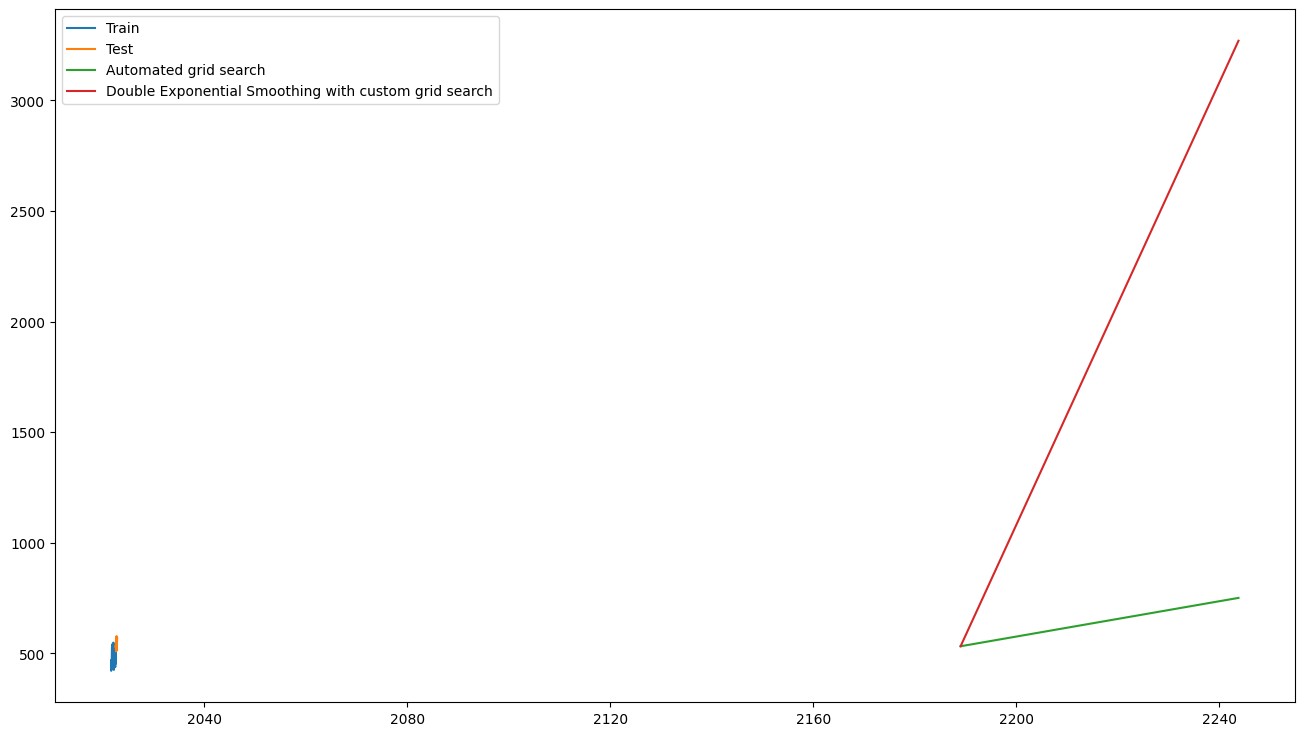

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(fitESAUTOpred, label='Automated grid search')
plt.plot(Forecast_custom_pred, label='Double Exponential Smoothing with custom grid search')
plt.legend(loc='best')
plt.show()

### CNN

In [ ]:
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [ ]:
def train_split_sequence(sequence, steps):
  X, y = list(), list()
  for start in range(0, len(sequence)-size):
    end_index = start + steps
    if end_index > len(sequence)-1:
      break
    sequence_x, sequence_y = sequence[start: end_index], sequence[end_index]
    X.append(sequence_x)
    y.append(sequence_y)
  return array(X), array(y)


def test_split_sequence(sequence, steps):
  X, y = list(), list()
  for start in range(len(sequence)-size, len(sequence)):
    end_index = start + steps
    if end_index > len(sequence)-1:
      break
    sequence_x, sequence_y = sequence[start: end_index], sequence[end_index]
    X.append(sequence_x)
    y.append(sequence_y)
  return array(X), array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(steps, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               89700     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 89993 (351.54 KB)
Trainable params: 89993 (351.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
model.compile(optimizer="adam", loss="mse")

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1000/1000 [==============================] - 5s 5ms/step - loss: 1.6525
Epoch 2/50
1000/1000 [==============================] - 4s 4ms/step - loss: 1.7211
Epoch 3/50
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9857
Epoch 4/50
1000/1000 [==============================] - 7s 7ms/step - loss: 2.6145
Epoch 5/50
1000/1000 [==============================] - 5s 5ms/step - loss: 3.6457
Epoch 6/50
1000/1000 [==============================] - 6s 6ms/step - loss: 4.9258
Epoch 7/50
1000/1000 [==============================] - 3s 3ms/step - loss: 7.2280
Epoch 8/50
1000/1000 [==============================] - 3s 3ms/step - loss: 4.0364
Epoch 9/50
1000/1000 [==============================] - 3s 3ms/step - loss: 4.3585
Epoch 10/50
1000/1000 [==============================] - 4s 4ms/step - loss: 3.8217
Epoch 11/50
1000/1000 [==============================] - 4s 4ms/step - loss: 4.2696
Epoch 12/50
1000/1000 [==============================] - 3s 3ms/step - loss: 3.4330
E

In [ ]:
y_pred = model.predict(X_test, verbose=0)

print(f"The next predicted output vs original is:")
data = pd.DataFrame(y_pred, columns=['y_pred'])
data["y_test"] = y_test
data.head()

The next predicted output vs original is:


,y_pred,y_test
0,515.656616,516.75
1,469.795502,471.00
2,514.838867,515.10
3,494.215424,496.00
4,486.781769,487.55


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred)

1.8902514804058488

In [ ]:
timeseries_evaluation_metrics_func(y_test, y_pred)

Evaluation metric results:-
MSE is : 1.8902514804058488
MAE is : 1.1366630592346194
RMSE is : 1.3748641679838227
MAPE is : 7.002558445872116
R2 is : 0.9979305148088515



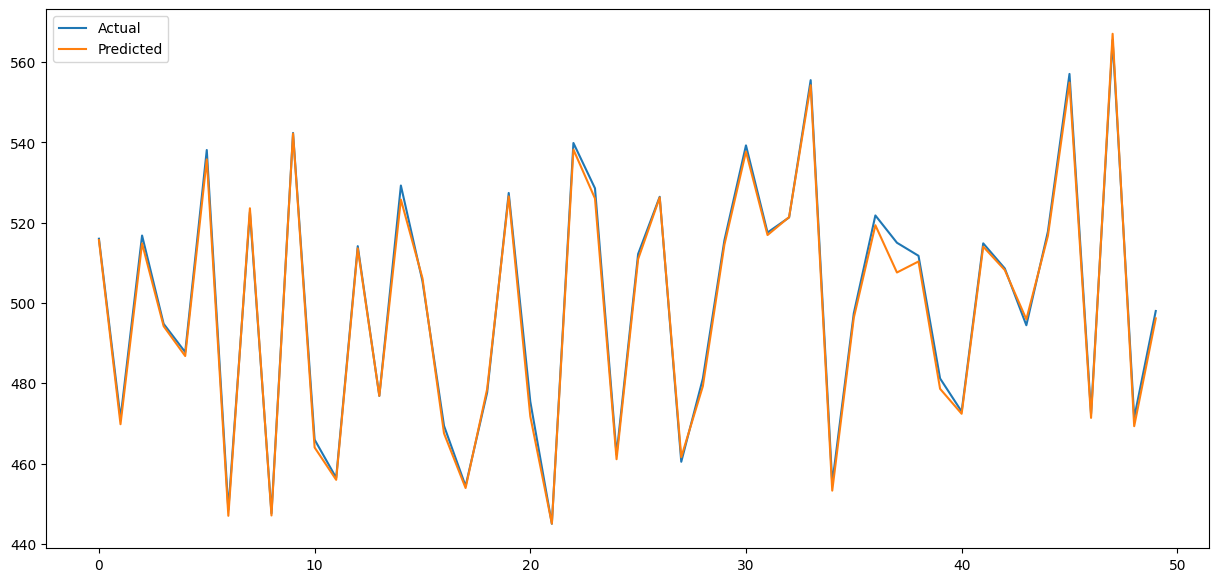

In [ ]:
X_original = np.squeeze(X_test)
plt.plot(X_original[:50, 0], label='Actual')
plt.plot(y_pred[:50,:], label='Predicted')
plt.legend()
plt.show()

### ARCH /GARCH

In [ ]:
!pip install arch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
model = arch_model(train, p=1, q=1)
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.forecast()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 66755506.33906698
Iteration:      2,   Func. Count:     13,   Neg. LLF: 439261.5367517399
Iteration:      3,   Func. Count:     20,   Neg. LLF: 178566.33334915328
Iteration:      4,   Func. Count:     25,   Neg. LLF: 178926.1764039513
Iteration:      5,   Func. Count:     40,   Neg. LLF: 180358.5146567932
Iteration:      6,   Func. Count:     47,   Neg. LLF: 178032.96927831386
Iteration:      7,   Func. Count:     54,   Neg. LLF: 177240.8561738868
Iteration:      8,   Func. Count:     60,   Neg. LLF: 177081.93610272132
Iteration:      9,   Func. Count:     68,   Neg. LLF: 177003.04920898404
Iteration:     10,   Func. Count:     73,   Neg. LLF: 177114.2578243474
Iteration:     11,   Func. Count:     81,   Neg. LLF: 176993.7516704339
Iteration:     12,   Func. Count:     87,   Neg. LLF: 176982.4306300631
Iteration:     13,   Func. Count:     92,   Neg. LLF: 176979.41793723125
Iteration:     14,   Func. Count:     97,   Neg. LLF: 17697

In [ ]:
def predict_volatility(column_name, p, q):
  new_df = df_sbi[column_name]
  rolling_predictions = []
  test_size = 30

  for i in range(test_size):
    train = new_df[:-(test_size-i)]

    model = arch_model(train, p=p, q=q)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

  rolling_predictions = pd.Series(rolling_predictions, index=new_df.index[-test_size:])

  plt.figure(figsize=(10,4))
  true, = plt.plot(df_sbi[column_name][-test_size:])
  preds, = plt.plot(rolling_predictions)
  plt.title(f'Volatility Prediction - Rolling forecast for GARCH[{p}, {q}]', fontsize=20)
  plt.legend([ 'True Volatility', 'Predicted Volatility'], fontsize=16)
  return rolling_predictions

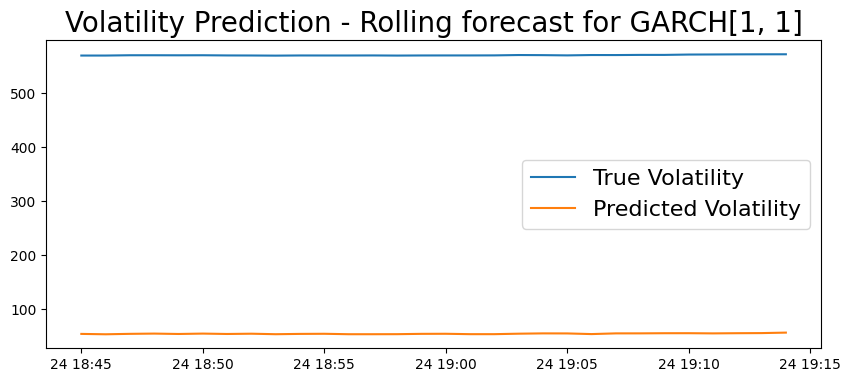

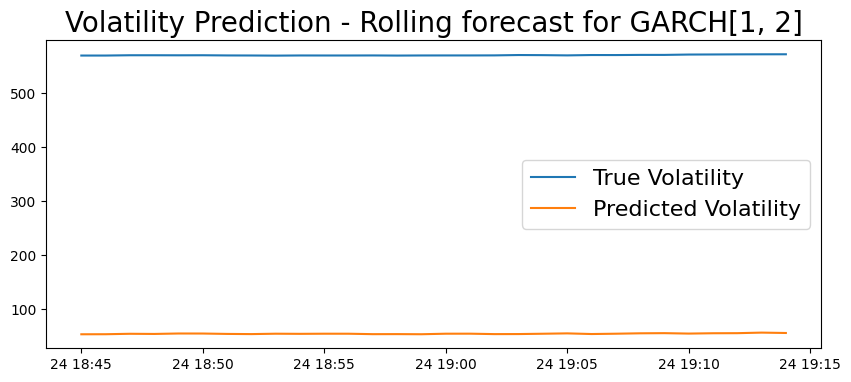

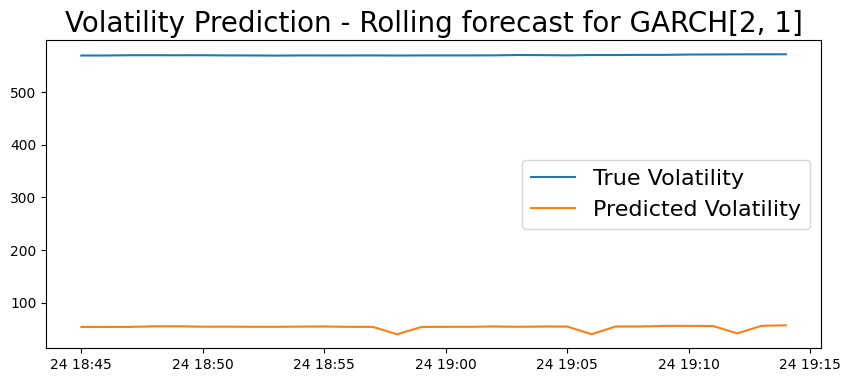

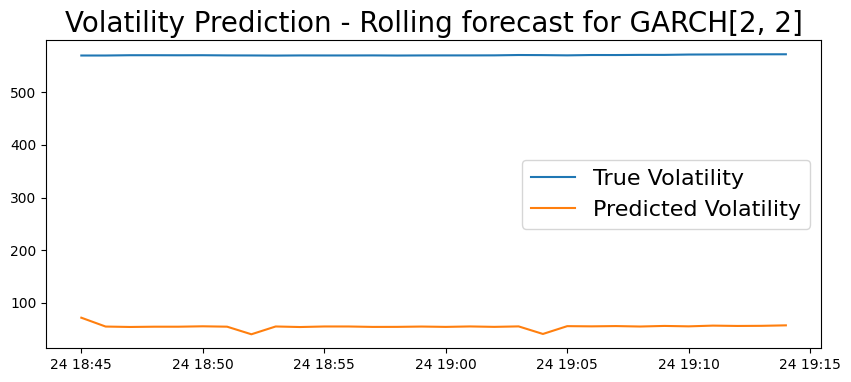

In [ ]:
for i in range(2):
  for j in range(2):
    predict_volatility("close", i+1, j+1)

In [ ]:
X = df_sbi[['close' ]]
train, test = X[0:-30], X[-30:]

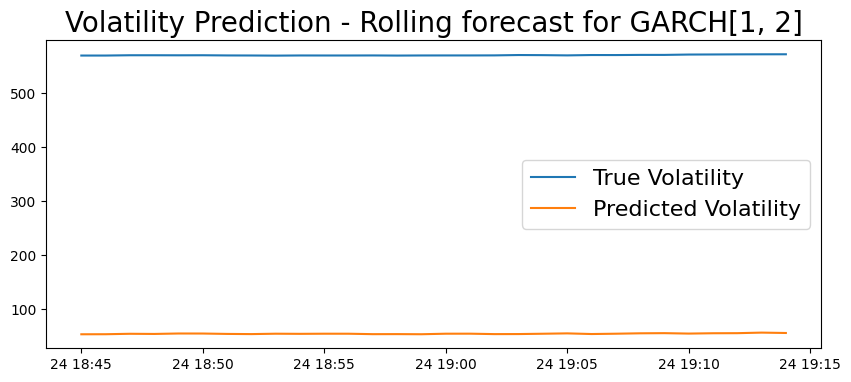

In [ ]:
forecast = predict_volatility("close", 1, 2)

In [ ]:
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 265767.7029156234
MAE is : 515.5263724967987
RMSE is : 515.5266267765646
MAPE is : 90.36631623189028
R2 is : -480135.7651246547



In [ ]:
# Extract date without time
df_sbi['Hour'] = df_sbi['date'].dt.hour
df_sbi['Minute'] = df_sbi['date'].dt.minute
df_sbi['Day'] = df_sbi['date'].dt.date

### Rolling window origin

In [ ]:
#forcasting
forecast_get = results.get_forecast(steps = test_size)

forecast_ = forecast_get.predicted_mean
conf_int_ = forecast_get.conf_int()

daterange  = df_diff.index[df_diff.index > pd.to_datetime("2021-04-09")]
forecast = pd.DataFrame({"pred": forecast_.values}, index=daterange)
df_conf = pd.DataFrame(conf_int_.values, columns=['Upper_bound', 'Lower_bound'], index=daterange)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-228-683e9b74df11>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  daterange  = df_diff.index[df_diff.index > pd.to_datetime("2021-04-09")]


In [ ]:
# forecast = pd.DataFrame(forecast.values, columns=['close_pred'], index=test.index)
# df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'], index=test.index)
df_conf